In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import joblib
import torch.optim as optim
from training_utils import train_and_get_losses, plot_learning_curve
from math import sqrt

In [25]:
df = pd.read_csv("../data/cleaned_data.csv")
scaler = joblib.load("scalers/minmax.save")

## Splitting data, converting to tensors

In [26]:
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

X = df.drop('price', axis=1).values 
y = df['price'].values

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

/tmp/ipykernel_9313/3186168220.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_9313/3186168220.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


## Defining model architecture

In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.leaky_relu1 = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.leaky_relu2 = nn.LeakyReLU(0.01)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.fc3(x)
        return x

## Initializing the model

In [28]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

model = NeuralNetwork(input_size, hidden_size, output_size)

## Hyperparameters

In [29]:
learning_rate = 0.004
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

num_epochs = 40
batch_size = 32
train_losses = [] 
test_losses = []  

## Training loop + eval

Epoch [1/40], Training Loss: 4531047.723890765, Test Loss: 82660344.0
Epoch [2/40], Training Loss: 1911832.8331852378, Test Loss: 51679176.0
Epoch [3/40], Training Loss: 1321029.388898762, Test Loss: 39604948.0
Epoch [4/40], Training Loss: 1039054.8939043896, Test Loss: 32497762.0
Epoch [5/40], Training Loss: 870333.7070226882, Test Loss: 28100664.0
Epoch [6/40], Training Loss: 759396.0613707718, Test Loss: 25064528.0
Epoch [7/40], Training Loss: 679267.5734405544, Test Loss: 22873072.0
Epoch [8/40], Training Loss: 618367.6571441265, Test Loss: 21239494.0
Epoch [9/40], Training Loss: 567800.5149428351, Test Loss: 19994162.0
Epoch [10/40], Training Loss: 527379.879894556, Test Loss: 19030200.0
Epoch [11/40], Training Loss: 493767.576905989, Test Loss: 18278700.0
Epoch [12/40], Training Loss: 464297.493528227, Test Loss: 17678112.0
Epoch [13/40], Training Loss: 440122.2535913157, Test Loss: 17206002.0
Epoch [14/40], Training Loss: 420701.5011107162, Test Loss: 16923962.0
Epoch [15/40], T

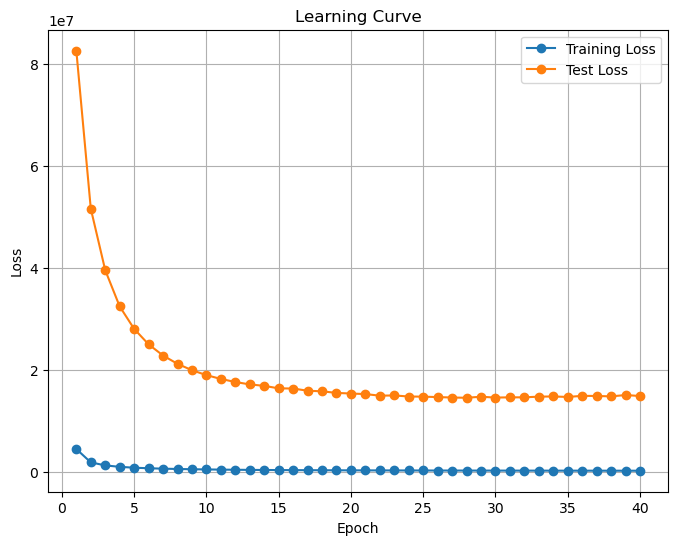

In [30]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()  
        outputs = model(batch_X)  
        loss = criterion(outputs, batch_y.view(-1, 1)) 

        loss.backward()  
        optimizer.step() 

        epoch_loss += loss.item()


    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        loss = criterion(test_outputs, y_test.view(-1, 1))
        model.train()

    train_losses.append(epoch_loss / len(X_train))
    test_losses.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

print(f"Train RMSE : {sqrt(train_losses[-1])}, Test RMSE : {sqrt(test_losses[-1])}")

plot_learning_curve(train_losses, test_losses)


## Testing different network + learning rate + batch size combinations

In [45]:
lr_vals = [0.1, 0.001, 0.2, 0.002, 0.3, 0.003, 0.4, 0.004]
batch_vals = [32, 64, 128, 211, 256, 512]
res_rmse = {}

In [46]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

for network in nns:
    for lr in lr_vals:
        for batch in batch_vals:
            model = NeuralNetwork3(input_size, hidden_size, output_size)
            res = train_and_get_losses(lr, batch, model, X_train, X_test, y_train, y_test)
            res_rmse[(lr,batch)] = res[1][-1]
            

Epoch [1/100], Training Loss: 7112453.418103193, Test Loss: 147780544.0
Epoch [2/100], Training Loss: 4041989.8180202595, Test Loss: 116578888.0
Epoch [3/100], Training Loss: 3223717.925122919, Test Loss: 95075936.0
Epoch [4/100], Training Loss: 2631642.048219892, Test Loss: 79484472.0
Epoch [5/100], Training Loss: 2196641.50097743, Test Loss: 67981656.0
Epoch [6/100], Training Loss: 1883549.684852793, Test Loss: 59695352.0
Epoch [7/100], Training Loss: 1661119.2263491498, Test Loss: 53716588.0
Epoch [8/100], Training Loss: 1496862.2647947397, Test Loss: 49111004.0
Epoch [9/100], Training Loss: 1365511.0611338192, Test Loss: 45283116.0
Epoch [10/100], Training Loss: 1254198.9274924472, Test Loss: 41954264.0
Epoch [11/100], Training Loss: 1157265.0034506249, Test Loss: 38988188.0
Epoch [12/100], Training Loss: 1072035.7704223683, Test Loss: 36324044.0
Epoch [13/100], Training Loss: 996993.8193975475, Test Loss: 33944420.0
Epoch [14/100], Training Loss: 930983.1860671762, Test Loss: 3183

Epoch [16/100], Training Loss: 609092.3230258871, Test Loss: 41842800.0
Epoch [17/100], Training Loss: 577589.2669569338, Test Loss: 39860660.0
Epoch [18/100], Training Loss: 548608.0315739589, Test Loss: 38011696.0
Epoch [19/100], Training Loss: 521918.32983827975, Test Loss: 36292472.0
Epoch [20/100], Training Loss: 497382.8394052485, Test Loss: 34698088.0
Epoch [21/100], Training Loss: 474836.1639713287, Test Loss: 33228006.0
Epoch [22/100], Training Loss: 454110.7870979207, Test Loss: 31871748.0
Epoch [23/100], Training Loss: 435078.9593922161, Test Loss: 30623376.0
Epoch [24/100], Training Loss: 417614.2968426041, Test Loss: 29476422.0
Epoch [25/100], Training Loss: 401580.3681357739, Test Loss: 28420736.0
Epoch [26/100], Training Loss: 386820.19776671997, Test Loss: 27445092.0
Epoch [27/100], Training Loss: 373250.9425537587, Test Loss: 26546634.0
Epoch [28/100], Training Loss: 360764.7962650317, Test Loss: 25718412.0
Epoch [29/100], Training Loss: 349245.69138380425, Test Loss: 

Epoch [31/100], Training Loss: 290081.47698596056, Test Loss: 40869132.0
Epoch [32/100], Training Loss: 282684.623126592, Test Loss: 39928016.0
Epoch [33/100], Training Loss: 275676.6139446715, Test Loss: 39031432.0
Epoch [34/100], Training Loss: 269032.67543391977, Test Loss: 38178456.0
Epoch [35/100], Training Loss: 262744.23505716486, Test Loss: 37368628.0
Epoch [36/100], Training Loss: 256792.66548190272, Test Loss: 36598812.0
Epoch [37/100], Training Loss: 251132.0315147207, Test Loss: 35864744.0
Epoch [38/100], Training Loss: 245704.53788282684, Test Loss: 35162400.0
Epoch [39/100], Training Loss: 240489.3101119602, Test Loss: 34487024.0
Epoch [40/100], Training Loss: 235478.50891534862, Test Loss: 33836484.0
Epoch [41/100], Training Loss: 230675.56945678574, Test Loss: 33214936.0
Epoch [42/100], Training Loss: 226121.77815295302, Test Loss: 32624576.0
Epoch [43/100], Training Loss: 221803.3724897814, Test Loss: 32063340.0
Epoch [44/100], Training Loss: 217687.74032936437, Test L

Epoch [44/100], Training Loss: 223783.01928203306, Test Loss: 52224732.0
Epoch [45/100], Training Loss: 219739.2824477223, Test Loss: 51380684.0
Epoch [46/100], Training Loss: 215774.3894022866, Test Loss: 50554288.0
Epoch [47/100], Training Loss: 211891.527397666, Test Loss: 49744704.0
Epoch [48/100], Training Loss: 208090.78067057638, Test Loss: 48951508.0
Epoch [49/100], Training Loss: 204367.50730110775, Test Loss: 48173892.0
Epoch [50/100], Training Loss: 200719.90384159706, Test Loss: 47411792.0
Epoch [51/100], Training Loss: 197147.35317812927, Test Loss: 46664296.0
Epoch [52/100], Training Loss: 193648.66434156743, Test Loss: 45930976.0
Epoch [53/100], Training Loss: 190221.82969018424, Test Loss: 45210824.0
Epoch [54/100], Training Loss: 186867.7078224039, Test Loss: 44503900.0
Epoch [55/100], Training Loss: 183587.43595610448, Test Loss: 43810060.0
Epoch [56/100], Training Loss: 180381.53117410105, Test Loss: 43129648.0
Epoch [57/100], Training Loss: 177248.53899354304, Test 

Epoch [58/100], Training Loss: 130426.43759255968, Test Loss: 37806472.0
Epoch [59/100], Training Loss: 128224.34837983531, Test Loss: 37226456.0
Epoch [60/100], Training Loss: 126080.7397666015, Test Loss: 36661584.0
Epoch [61/100], Training Loss: 123995.29879746461, Test Loss: 36111744.0
Epoch [62/100], Training Loss: 121966.24773413897, Test Loss: 35576580.0
Epoch [63/100], Training Loss: 119994.1753450625, Test Loss: 35056080.0
Epoch [64/100], Training Loss: 118077.43581541377, Test Loss: 34549636.0
Epoch [65/100], Training Loss: 116214.76903027072, Test Loss: 34056216.0
Epoch [66/100], Training Loss: 114402.66992476748, Test Loss: 33575324.0
Epoch [67/100], Training Loss: 112639.42787749541, Test Loss: 33106366.0
Epoch [68/100], Training Loss: 110924.74012203068, Test Loss: 32649818.0
Epoch [69/100], Training Loss: 109256.53794206504, Test Loss: 32205096.0
Epoch [70/100], Training Loss: 107635.86452224394, Test Loss: 31772594.0
Epoch [71/100], Training Loss: 106063.3374207689, Tes

Epoch [72/100], Training Loss: 88091.55464723654, Test Loss: 50160928.0
Epoch [73/100], Training Loss: 87007.14069071738, Test Loss: 49613552.0
Epoch [74/100], Training Loss: 85942.8450921154, Test Loss: 49075920.0
Epoch [75/100], Training Loss: 84897.08713938748, Test Loss: 48545312.0
Epoch [76/100], Training Loss: 83866.54368817013, Test Loss: 48022096.0
Epoch [77/100], Training Loss: 82852.61678810498, Test Loss: 47508416.0
Epoch [78/100], Training Loss: 81859.35596232451, Test Loss: 47004872.0
Epoch [79/100], Training Loss: 80886.75114033528, Test Loss: 46510012.0
Epoch [80/100], Training Loss: 79932.41691842901, Test Loss: 46023784.0
Epoch [81/100], Training Loss: 78996.53598720455, Test Loss: 45545080.0
Epoch [82/100], Training Loss: 78078.42224986671, Test Loss: 45073888.0
Epoch [83/100], Training Loss: 77176.9870268349, Test Loss: 44609804.0
Epoch [84/100], Training Loss: 76292.23328001896, Test Loss: 44153760.0
Epoch [85/100], Training Loss: 75423.82797227653, Test Loss: 43705

Epoch [86/100], Training Loss: 282316.8989692554, Test Loss: 15054169.0
Epoch [87/100], Training Loss: 280843.6313681062, Test Loss: 15067752.0
Epoch [88/100], Training Loss: 279440.0856140039, Test Loss: 15011274.0
Epoch [89/100], Training Loss: 278003.2504961199, Test Loss: 15043968.0
Epoch [90/100], Training Loss: 276596.4228348439, Test Loss: 15034519.0
Epoch [91/100], Training Loss: 275270.40646288724, Test Loss: 15007415.0
Epoch [92/100], Training Loss: 273913.7210177122, Test Loss: 15062881.0
Epoch [93/100], Training Loss: 272654.57437355607, Test Loss: 14991679.0
Epoch [94/100], Training Loss: 271343.2247608258, Test Loss: 15033107.0
Epoch [95/100], Training Loss: 270113.3382352941, Test Loss: 14988899.0
Epoch [96/100], Training Loss: 268899.5796790771, Test Loss: 15010429.0
Epoch [97/100], Training Loss: 267718.19124311354, Test Loss: 15042666.0
Epoch [98/100], Training Loss: 266572.25091819203, Test Loss: 14983411.0
Epoch [99/100], Training Loss: 265423.8738707719, Test Loss:

Epoch [100/100], Training Loss: 137819.28082607666, Test Loss: 14442947.0
Epoch [1/100], Training Loss: 2316234.0723890765, Test Loss: 291172256.0
Epoch [2/100], Training Loss: 2031819.0751732718, Test Loss: 220678480.0
Epoch [3/100], Training Loss: 1421049.8143474914, Test Loss: 157575968.0
Epoch [4/100], Training Loss: 1141202.284461821, Test Loss: 139597952.0
Epoch [5/100], Training Loss: 1029887.2682897933, Test Loss: 127738072.0
Epoch [6/100], Training Loss: 941640.1085243765, Test Loss: 117453464.0
Epoch [7/100], Training Loss: 862656.22700077, Test Loss: 108068152.0
Epoch [8/100], Training Loss: 789509.6330786091, Test Loss: 99562112.0
Epoch [9/100], Training Loss: 725257.5533439962, Test Loss: 92318064.0
Epoch [10/100], Training Loss: 669991.3360582904, Test Loss: 86074456.0
Epoch [11/100], Training Loss: 622148.8549256561, Test Loss: 80640344.0
Epoch [12/100], Training Loss: 580637.1307387003, Test Loss: 75897296.0
Epoch [13/100], Training Loss: 544688.6901249926, Test Loss: 7

Epoch [15/100], Training Loss: 453216.4191694805, Test Loss: 93861560.0
Epoch [16/100], Training Loss: 432806.032817961, Test Loss: 90536208.0
Epoch [17/100], Training Loss: 414413.37716959894, Test Loss: 87533864.0
Epoch [18/100], Training Loss: 397772.47722291335, Test Loss: 84804168.0
Epoch [19/100], Training Loss: 382681.239618506, Test Loss: 82310128.0
Epoch [20/100], Training Loss: 368994.7692672235, Test Loss: 80025784.0
Epoch [21/100], Training Loss: 356576.454238493, Test Loss: 77927272.0
Epoch [22/100], Training Loss: 345298.3672768201, Test Loss: 75990120.0
Epoch [23/100], Training Loss: 335037.1400983354, Test Loss: 74201504.0
Epoch [24/100], Training Loss: 325692.3388424856, Test Loss: 72542440.0
Epoch [25/100], Training Loss: 317158.51027782715, Test Loss: 70997224.0
Epoch [26/100], Training Loss: 309328.3726082578, Test Loss: 69548112.0
Epoch [27/100], Training Loss: 302104.3889580001, Test Loss: 68183968.0
Epoch [28/100], Training Loss: 295403.7984124163, Test Loss: 668

Epoch [29/100], Training Loss: 231420.52639061667, Test Loss: 63190752.0
Epoch [30/100], Training Loss: 225568.65268645223, Test Loss: 61743420.0
Epoch [31/100], Training Loss: 220067.97215804752, Test Loss: 60379340.0
Epoch [32/100], Training Loss: 214885.36117528583, Test Loss: 59090076.0
Epoch [33/100], Training Loss: 209980.4388365618, Test Loss: 57868832.0
Epoch [34/100], Training Loss: 205333.3502754576, Test Loss: 56710408.0
Epoch [35/100], Training Loss: 200914.64889520762, Test Loss: 55611140.0
Epoch [36/100], Training Loss: 196705.45879983413, Test Loss: 54563380.0
Epoch [37/100], Training Loss: 192678.69533795392, Test Loss: 53561380.0
Epoch [38/100], Training Loss: 188824.03080386232, Test Loss: 52601076.0
Epoch [39/100], Training Loss: 185128.99141046146, Test Loss: 51674768.0
Epoch [40/100], Training Loss: 181581.53557253716, Test Loss: 50783376.0
Epoch [41/100], Training Loss: 178167.88898761923, Test Loss: 49927448.0
Epoch [42/100], Training Loss: 174878.0738107932, Tes

Epoch [42/100], Training Loss: 136668.69995853325, Test Loss: 74209608.0
Epoch [43/100], Training Loss: 134156.04739055742, Test Loss: 73000952.0
Epoch [44/100], Training Loss: 131752.40542621881, Test Loss: 71840304.0
Epoch [45/100], Training Loss: 129451.89005390675, Test Loss: 70726008.0
Epoch [46/100], Training Loss: 127247.89360819856, Test Loss: 69653840.0
Epoch [47/100], Training Loss: 125133.21201350632, Test Loss: 68619632.0
Epoch [48/100], Training Loss: 123101.04590960252, Test Loss: 67622376.0
Epoch [49/100], Training Loss: 121147.16568923643, Test Loss: 66661220.0
Epoch [50/100], Training Loss: 119269.03216634085, Test Loss: 65733184.0
Epoch [51/100], Training Loss: 117459.48557549909, Test Loss: 64834340.0
Epoch [52/100], Training Loss: 115713.37930217404, Test Loss: 63964188.0
Epoch [53/100], Training Loss: 114027.48936674367, Test Loss: 63121600.0
Epoch [54/100], Training Loss: 112398.30555061904, Test Loss: 62304900.0
Epoch [55/100], Training Loss: 110820.5037616255, T

Epoch [56/100], Training Loss: 323207.907358865, Test Loss: 14804283.0
Epoch [57/100], Training Loss: 320205.1526012973, Test Loss: 14796020.0
Epoch [58/100], Training Loss: 317292.29439902847, Test Loss: 14727570.0
Epoch [59/100], Training Loss: 314555.0161535158, Test Loss: 14707621.0
Epoch [60/100], Training Loss: 311927.86982406257, Test Loss: 14655581.0
Epoch [61/100], Training Loss: 309437.40246801137, Test Loss: 14640192.0
Epoch [62/100], Training Loss: 307052.5408077128, Test Loss: 14587735.0
Epoch [63/100], Training Loss: 304795.7042162787, Test Loss: 14582317.0
Epoch [64/100], Training Loss: 302617.53035587346, Test Loss: 14537559.0
Epoch [65/100], Training Loss: 300543.297864463, Test Loss: 14527088.0
Epoch [66/100], Training Loss: 298508.7329208874, Test Loss: 14488342.0
Epoch [67/100], Training Loss: 296595.7264972454, Test Loss: 14493131.0
Epoch [68/100], Training Loss: 294723.98182498076, Test Loss: 14475666.0
Epoch [69/100], Training Loss: 292937.0520888869, Test Loss: 

Epoch [70/100], Training Loss: 171757.26634233753, Test Loss: 15328426.0
Epoch [71/100], Training Loss: 170093.4613174575, Test Loss: 15281532.0
Epoch [72/100], Training Loss: 168480.92294591552, Test Loss: 15235668.0
Epoch [73/100], Training Loss: 166939.9274109946, Test Loss: 15190294.0
Epoch [74/100], Training Loss: 165455.56879035602, Test Loss: 15153606.0
Epoch [75/100], Training Loss: 164039.04368076535, Test Loss: 15103010.0
Epoch [76/100], Training Loss: 162664.4388365618, Test Loss: 15059916.0
Epoch [77/100], Training Loss: 161357.9703512825, Test Loss: 15027218.0
Epoch [78/100], Training Loss: 160088.98759700256, Test Loss: 14980259.0
Epoch [79/100], Training Loss: 158883.0592604111, Test Loss: 14963192.0
Epoch [80/100], Training Loss: 157709.36299686038, Test Loss: 14896606.0
Epoch [81/100], Training Loss: 156596.24789704403, Test Loss: 14898909.0
Epoch [82/100], Training Loss: 155510.0962842841, Test Loss: 14843523.0
Epoch [83/100], Training Loss: 154466.96389431905, Test L

Epoch [83/100], Training Loss: 110085.52185889462, Test Loss: 17903706.0
Epoch [84/100], Training Loss: 108872.32252236242, Test Loss: 17783100.0
Epoch [85/100], Training Loss: 107690.40978022628, Test Loss: 17664914.0
Epoch [86/100], Training Loss: 106538.11187133464, Test Loss: 17549104.0
Epoch [87/100], Training Loss: 105416.40074640128, Test Loss: 17439512.0
Epoch [88/100], Training Loss: 104325.48105858658, Test Loss: 17331940.0
Epoch [89/100], Training Loss: 103261.34276701618, Test Loss: 17230076.0
Epoch [90/100], Training Loss: 102225.31039334163, Test Loss: 17132154.0
Epoch [91/100], Training Loss: 101217.44570819264, Test Loss: 17036748.0
Epoch [92/100], Training Loss: 100234.89448196196, Test Loss: 16947368.0
Epoch [93/100], Training Loss: 99280.2159232273, Test Loss: 16860876.0
Epoch [94/100], Training Loss: 98346.25531662816, Test Loss: 16777708.0
Epoch [95/100], Training Loss: 97439.4391623719, Test Loss: 16700070.0
Epoch [96/100], Training Loss: 96558.30667614478, Test L

Epoch [98/100], Training Loss: 105923.32773856333, Test Loss: 26920146.0
Epoch [99/100], Training Loss: 104909.64697505701, Test Loss: 26706840.0
Epoch [100/100], Training Loss: 103914.07620762617, Test Loss: 26496256.0
Epoch [1/100], Training Loss: 1164524.6106273325, Test Loss: 299480864.0
Epoch [2/100], Training Loss: 1152489.8733487353, Test Loss: 292161184.0
Epoch [3/100], Training Loss: 1094964.9760085302, Test Loss: 268461120.0
Epoch [4/100], Training Loss: 967902.0280789053, Test Loss: 227992880.0
Epoch [5/100], Training Loss: 801588.7039867307, Test Loss: 186561792.0
Epoch [6/100], Training Loss: 667810.4287660683, Test Loss: 160747184.0
Epoch [7/100], Training Loss: 595006.2060304484, Test Loss: 147876736.0
Epoch [8/100], Training Loss: 554832.2902671642, Test Loss: 139612112.0
Epoch [9/100], Training Loss: 525120.9077661276, Test Loss: 132822440.0
Epoch [10/100], Training Loss: 499324.90539659973, Test Loss: 126729688.0
Epoch [11/100], Training Loss: 475672.91819205025, Test

Epoch [12/100], Training Loss: 303936.20520111365, Test Loss: 152813248.0
Epoch [13/100], Training Loss: 289093.723357621, Test Loss: 146406032.0
Epoch [14/100], Training Loss: 277757.707718737, Test Loss: 141280752.0
Epoch [15/100], Training Loss: 268243.63722528284, Test Loss: 136833568.0
Epoch [16/100], Training Loss: 259739.13772880755, Test Loss: 132787768.0
Epoch [17/100], Training Loss: 251870.8081274806, Test Loss: 129012720.0
Epoch [18/100], Training Loss: 244452.87506664297, Test Loss: 125439432.0
Epoch [19/100], Training Loss: 237381.69397547538, Test Loss: 122027688.0
Epoch [20/100], Training Loss: 230595.03252177004, Test Loss: 118752984.0
Epoch [21/100], Training Loss: 224054.87921331674, Test Loss: 115600368.0
Epoch [22/100], Training Loss: 217738.7455719448, Test Loss: 112561176.0
Epoch [23/100], Training Loss: 211634.08565843257, Test Loss: 109630848.0
Epoch [24/100], Training Loss: 205735.6031040815, Test Loss: 106807904.0
Epoch [25/100], Training Loss: 200043.0483976

Epoch [26/100], Training Loss: 539095.0037320064, Test Loss: 19479664.0
Epoch [27/100], Training Loss: 522130.58977548726, Test Loss: 19016406.0
Epoch [28/100], Training Loss: 506408.08953853446, Test Loss: 18600248.0
Epoch [29/100], Training Loss: 491874.0609264854, Test Loss: 18222140.0
Epoch [30/100], Training Loss: 478365.72812629584, Test Loss: 17876290.0
Epoch [31/100], Training Loss: 465783.2802336947, Test Loss: 17559024.0
Epoch [32/100], Training Loss: 454080.6538045732, Test Loss: 17268786.0
Epoch [33/100], Training Loss: 443134.8888765476, Test Loss: 17009074.0
Epoch [34/100], Training Loss: 432861.2546131746, Test Loss: 16767782.0
Epoch [35/100], Training Loss: 423216.28422486817, Test Loss: 16560319.0
Epoch [36/100], Training Loss: 414155.48680469167, Test Loss: 16363979.0
Epoch [37/100], Training Loss: 405687.60140098335, Test Loss: 16190842.0
Epoch [38/100], Training Loss: 397743.52753095195, Test Loss: 16053892.0
Epoch [39/100], Training Loss: 390289.6311237486, Test Lo

Epoch [40/100], Training Loss: 261775.41733309638, Test Loss: 19438532.0
Epoch [41/100], Training Loss: 256124.7213731414, Test Loss: 19115846.0
Epoch [42/100], Training Loss: 250750.63749185475, Test Loss: 18817276.0
Epoch [43/100], Training Loss: 245651.28249215093, Test Loss: 18537474.0
Epoch [44/100], Training Loss: 240783.66437118655, Test Loss: 18273158.0
Epoch [45/100], Training Loss: 236145.8254398436, Test Loss: 18025932.0
Epoch [46/100], Training Loss: 231702.56519163557, Test Loss: 17793568.0
Epoch [47/100], Training Loss: 227480.76590545583, Test Loss: 17578378.0
Epoch [48/100], Training Loss: 223438.0172827439, Test Loss: 17373344.0
Epoch [49/100], Training Loss: 219588.89498548664, Test Loss: 17184022.0
Epoch [50/100], Training Loss: 215893.59595106926, Test Loss: 17005022.0
Epoch [51/100], Training Loss: 212364.35735442213, Test Loss: 16842364.0
Epoch [52/100], Training Loss: 208994.24484627688, Test Loss: 16687913.0
Epoch [53/100], Training Loss: 205769.75010366685, Tes

Epoch [54/100], Training Loss: 184616.73511640306, Test Loss: 27216910.0
Epoch [55/100], Training Loss: 181484.6997215805, Test Loss: 26807198.0
Epoch [56/100], Training Loss: 178418.3413304899, Test Loss: 26405812.0
Epoch [57/100], Training Loss: 175465.2062970203, Test Loss: 26021646.0
Epoch [58/100], Training Loss: 172640.52467270897, Test Loss: 25652426.0
Epoch [59/100], Training Loss: 169936.83890172382, Test Loss: 25301610.0
Epoch [60/100], Training Loss: 167351.11578105562, Test Loss: 24966264.0
Epoch [61/100], Training Loss: 164864.70446063622, Test Loss: 24646802.0
Epoch [62/100], Training Loss: 162450.3409158225, Test Loss: 24335908.0
Epoch [63/100], Training Loss: 160084.07455127066, Test Loss: 24033460.0
Epoch [64/100], Training Loss: 157756.29210354836, Test Loss: 23735106.0
Epoch [65/100], Training Loss: 155477.6176766779, Test Loss: 23441936.0
Epoch [66/100], Training Loss: 153254.76440969136, Test Loss: 23158268.0
Epoch [67/100], Training Loss: 151104.68580060423, Test 

Epoch [68/100], Training Loss: 141607.87909229496, Test Loss: 34707892.0
Epoch [69/100], Training Loss: 139332.3330510263, Test Loss: 34203304.0
Epoch [70/100], Training Loss: 137115.62646498837, Test Loss: 33711132.0
Epoch [71/100], Training Loss: 134957.6239813807, Test Loss: 33230928.0
Epoch [72/100], Training Loss: 132856.11511479947, Test Loss: 32762920.0
Epoch [73/100], Training Loss: 130809.79497132935, Test Loss: 32306950.0
Epoch [74/100], Training Loss: 128818.30147883545, Test Loss: 31863422.0
Epoch [75/100], Training Loss: 126879.87441469017, Test Loss: 31431316.0
Epoch [76/100], Training Loss: 124992.81776716658, Test Loss: 31011172.0
Epoch [77/100], Training Loss: 123156.31258146698, Test Loss: 30602896.0
Epoch [78/100], Training Loss: 121369.02890543432, Test Loss: 30205556.0
Epoch [79/100], Training Loss: 119628.69084192518, Test Loss: 29818520.0
Epoch [80/100], Training Loss: 117933.6630704916, Test Loss: 29440530.0
Epoch [81/100], Training Loss: 116280.2586013399, Test

Epoch [81/100], Training Loss: 105495.57893489722, Test Loss: 31291558.0
Epoch [82/100], Training Loss: 104508.00432438837, Test Loss: 31032558.0
Epoch [83/100], Training Loss: 103533.67851430603, Test Loss: 30779534.0
Epoch [84/100], Training Loss: 102581.89751791955, Test Loss: 30533456.0
Epoch [85/100], Training Loss: 101658.17783306676, Test Loss: 30295074.0
Epoch [86/100], Training Loss: 100761.8818790356, Test Loss: 30061854.0
Epoch [87/100], Training Loss: 99886.7288075351, Test Loss: 29835834.0
Epoch [88/100], Training Loss: 99023.46762632545, Test Loss: 29610128.0
Epoch [89/100], Training Loss: 98164.35199336532, Test Loss: 29388460.0
Epoch [90/100], Training Loss: 97303.92358272614, Test Loss: 29167700.0
Epoch [91/100], Training Loss: 96453.3117113915, Test Loss: 28950590.0
Epoch [92/100], Training Loss: 95621.86783958296, Test Loss: 28740032.0
Epoch [93/100], Training Loss: 94811.86298205082, Test Loss: 28537150.0
Epoch [94/100], Training Loss: 94016.3485575499, Test Loss: 2

Epoch [96/100], Training Loss: 71408.7250755287, Test Loss: 41515288.0
Epoch [97/100], Training Loss: 70738.6272140276, Test Loss: 41169456.0
Epoch [98/100], Training Loss: 70078.67128724602, Test Loss: 40828608.0
Epoch [99/100], Training Loss: 69428.51217344945, Test Loss: 40492532.0
Epoch [100/100], Training Loss: 68787.84538830638, Test Loss: 40160940.0
Epoch [1/100], Training Loss: 7220604.4142527105, Test Loss: 149692064.0
Epoch [2/100], Training Loss: 4101697.8896984775, Test Loss: 118724120.0
Epoch [3/100], Training Loss: 3285495.250162905, Test Loss: 96810632.0
Epoch [4/100], Training Loss: 2687201.746460518, Test Loss: 81231376.0
Epoch [5/100], Training Loss: 2253127.0754694627, Test Loss: 69778064.0
Epoch [6/100], Training Loss: 1942804.2006990106, Test Loss: 61585884.0
Epoch [7/100], Training Loss: 1723883.0972395001, Test Loss: 55677892.0
Epoch [8/100], Training Loss: 1564199.9210947219, Test Loss: 51238004.0
Epoch [9/100], Training Loss: 1440201.4633315562, Test Loss: 4766

Epoch [10/100], Training Loss: 899632.5546472365, Test Loss: 59212560.0
Epoch [11/100], Training Loss: 833003.1552633138, Test Loss: 55393112.0
Epoch [12/100], Training Loss: 777963.538534447, Test Loss: 52163944.0
Epoch [13/100], Training Loss: 730725.6911912801, Test Loss: 49337828.0
Epoch [14/100], Training Loss: 688892.514720692, Test Loss: 46803156.0
Epoch [15/100], Training Loss: 651176.4304247379, Test Loss: 44488092.0
Epoch [16/100], Training Loss: 616716.9312244535, Test Loss: 42346568.0
Epoch [17/100], Training Loss: 585035.223357621, Test Loss: 40357144.0
Epoch [18/100], Training Loss: 555874.0267460458, Test Loss: 38503372.0
Epoch [19/100], Training Loss: 529013.9585332623, Test Loss: 36777452.0
Epoch [20/100], Training Loss: 504287.16166103905, Test Loss: 35172352.0
Epoch [21/100], Training Loss: 481475.54736093833, Test Loss: 33687208.0
Epoch [22/100], Training Loss: 460478.465671465, Test Loss: 32315176.0
Epoch [23/100], Training Loss: 441175.42912149755, Test Loss: 3105

Epoch [24/100], Training Loss: 363741.16545228363, Test Loss: 50212420.0
Epoch [25/100], Training Loss: 351937.251347669, Test Loss: 48750572.0
Epoch [26/100], Training Loss: 340760.18132812035, Test Loss: 47360608.0
Epoch [27/100], Training Loss: 330147.96232450684, Test Loss: 46036760.0
Epoch [28/100], Training Loss: 320058.23410935374, Test Loss: 44771408.0
Epoch [29/100], Training Loss: 310438.55417333095, Test Loss: 43556984.0
Epoch [30/100], Training Loss: 301245.1864226053, Test Loss: 42390124.0
Epoch [31/100], Training Loss: 292457.07078964513, Test Loss: 41268924.0
Epoch [32/100], Training Loss: 284056.26799360226, Test Loss: 40189912.0
Epoch [33/100], Training Loss: 276023.88667732954, Test Loss: 39151840.0
Epoch [34/100], Training Loss: 268348.3468988804, Test Loss: 38153628.0
Epoch [35/100], Training Loss: 261016.73881879036, Test Loss: 37195552.0
Epoch [36/100], Training Loss: 254008.52674604586, Test Loss: 36276008.0
Epoch [37/100], Training Loss: 247307.05994905514, Test

Epoch [38/100], Training Loss: 256894.35129176293, Test Loss: 59066156.0
Epoch [39/100], Training Loss: 252665.1776812689, Test Loss: 58172340.0
Epoch [40/100], Training Loss: 248521.37764720691, Test Loss: 57295044.0
Epoch [41/100], Training Loss: 244445.83620638587, Test Loss: 56434260.0
Epoch [42/100], Training Loss: 240440.84974971862, Test Loss: 55588880.0
Epoch [43/100], Training Loss: 236508.94721876667, Test Loss: 54758036.0
Epoch [44/100], Training Loss: 232642.60528849, Test Loss: 53943808.0
Epoch [45/100], Training Loss: 228844.80706119305, Test Loss: 53149712.0
Epoch [46/100], Training Loss: 225117.46650079972, Test Loss: 52369756.0
Epoch [47/100], Training Loss: 221445.9906403649, Test Loss: 51605300.0
Epoch [48/100], Training Loss: 217857.72366862153, Test Loss: 50859524.0
Epoch [49/100], Training Loss: 214364.37171968486, Test Loss: 50128596.0
Epoch [50/100], Training Loss: 210953.14254191102, Test Loss: 49419204.0
Epoch [51/100], Training Loss: 207618.56750192525, Test 

Epoch [52/100], Training Loss: 148489.28179610212, Test Loss: 42352916.0
Epoch [53/100], Training Loss: 146533.69053965996, Test Loss: 41853376.0
Epoch [54/100], Training Loss: 144637.02719033233, Test Loss: 41368024.0
Epoch [55/100], Training Loss: 142789.317575973, Test Loss: 40896324.0
Epoch [56/100], Training Loss: 140986.85089745867, Test Loss: 40434184.0
Epoch [57/100], Training Loss: 139232.4060186008, Test Loss: 39982992.0
Epoch [58/100], Training Loss: 137538.12487411883, Test Loss: 39547540.0
Epoch [59/100], Training Loss: 135910.26106273325, Test Loss: 39129900.0
Epoch [60/100], Training Loss: 134351.2784787631, Test Loss: 38728784.0
Epoch [61/100], Training Loss: 132857.43516379362, Test Loss: 38346208.0
Epoch [62/100], Training Loss: 131424.18423079202, Test Loss: 37979452.0
Epoch [63/100], Training Loss: 130049.28558734672, Test Loss: 37625264.0
Epoch [64/100], Training Loss: 128724.35128250696, Test Loss: 37281752.0
Epoch [65/100], Training Loss: 127439.35483679877, Test

Epoch [66/100], Training Loss: 98646.61110123807, Test Loss: 55347172.0
Epoch [67/100], Training Loss: 97509.66565961733, Test Loss: 54771544.0
Epoch [68/100], Training Loss: 96399.90000592382, Test Loss: 54209576.0
Epoch [69/100], Training Loss: 95317.51199573485, Test Loss: 53662120.0
Epoch [70/100], Training Loss: 94260.0312777679, Test Loss: 53126408.0
Epoch [71/100], Training Loss: 93225.82619513062, Test Loss: 52603280.0
Epoch [72/100], Training Loss: 92214.73099934838, Test Loss: 52091876.0
Epoch [73/100], Training Loss: 91225.78449144008, Test Loss: 51590792.0
Epoch [74/100], Training Loss: 90258.09940169421, Test Loss: 51098672.0
Epoch [75/100], Training Loss: 89311.53758663587, Test Loss: 50617100.0
Epoch [76/100], Training Loss: 88384.70600082933, Test Loss: 50147488.0
Epoch [77/100], Training Loss: 87478.6215271607, Test Loss: 49688296.0
Epoch [78/100], Training Loss: 86593.84005686866, Test Loss: 49240172.0
Epoch [79/100], Training Loss: 85730.60813932824, Test Loss: 48801

Epoch [80/100], Training Loss: 267587.1467182039, Test Loss: 14522132.0
Epoch [81/100], Training Loss: 266377.89331570995, Test Loss: 14549947.0
Epoch [82/100], Training Loss: 265233.293791837, Test Loss: 14540036.0
Epoch [83/100], Training Loss: 264130.15296413127, Test Loss: 14588701.0
Epoch [84/100], Training Loss: 263017.54355858656, Test Loss: 14485881.0
Epoch [85/100], Training Loss: 261919.1149443161, Test Loss: 14581993.0
Epoch [86/100], Training Loss: 260849.5293562289, Test Loss: 14542297.0
Epoch [87/100], Training Loss: 259805.2710110479, Test Loss: 14558483.0
Epoch [88/100], Training Loss: 258732.51931165214, Test Loss: 14567808.0
Epoch [89/100], Training Loss: 257662.3001155145, Test Loss: 14579419.0
Epoch [90/100], Training Loss: 256619.99281736865, Test Loss: 14532409.0
Epoch [91/100], Training Loss: 255596.4956237782, Test Loss: 14635217.0
Epoch [92/100], Training Loss: 254583.8732265565, Test Loss: 14547578.0
Epoch [93/100], Training Loss: 253614.09285587346, Test Loss

Epoch [95/100], Training Loss: 159124.37324506842, Test Loss: 15252173.0
Epoch [96/100], Training Loss: 158242.75260648064, Test Loss: 15226454.0
Epoch [97/100], Training Loss: 157393.1401871927, Test Loss: 15193460.0
Epoch [98/100], Training Loss: 156559.92195367574, Test Loss: 15158474.0
Epoch [99/100], Training Loss: 155750.46949973342, Test Loss: 15120753.0
Epoch [100/100], Training Loss: 154960.6896288727, Test Loss: 15145745.0
Epoch [1/100], Training Loss: 2316714.064806587, Test Loss: 291625248.0
Epoch [2/100], Training Loss: 2052049.0046798175, Test Loss: 225798368.0
Epoch [3/100], Training Loss: 1457883.6675552395, Test Loss: 160568880.0
Epoch [4/100], Training Loss: 1157734.316924353, Test Loss: 141337808.0
Epoch [5/100], Training Loss: 1043900.6321900361, Test Loss: 129533568.0
Epoch [6/100], Training Loss: 956716.2127836029, Test Loss: 119402600.0
Epoch [7/100], Training Loss: 879268.003317339, Test Loss: 110292416.0
Epoch [8/100], Training Loss: 809268.6120490492, Test Los

Epoch [8/100], Training Loss: 661755.3692316806, Test Loss: 129662936.0
Epoch [9/100], Training Loss: 623107.6353296606, Test Loss: 122869912.0
Epoch [10/100], Training Loss: 588130.0877910076, Test Loss: 116747064.0
Epoch [11/100], Training Loss: 556136.8653515787, Test Loss: 111206640.0
Epoch [12/100], Training Loss: 526837.4053669806, Test Loss: 106201120.0
Epoch [13/100], Training Loss: 500061.32693560806, Test Loss: 101685512.0
Epoch [14/100], Training Loss: 475505.9906403649, Test Loss: 97546648.0
Epoch [15/100], Training Loss: 452580.5409632131, Test Loss: 93736664.0
Epoch [16/100], Training Loss: 431623.881997512, Test Loss: 90329960.0
Epoch [17/100], Training Loss: 412961.055387714, Test Loss: 87304280.0
Epoch [18/100], Training Loss: 396226.7993602275, Test Loss: 84561616.0
Epoch [19/100], Training Loss: 381047.9534387773, Test Loss: 82038360.0
Epoch [20/100], Training Loss: 367067.0217404182, Test Loss: 79683784.0
Epoch [21/100], Training Loss: 354144.9763639595, Test Loss: 

Epoch [21/100], Training Loss: 292178.9793258693, Test Loss: 77774480.0
Epoch [22/100], Training Loss: 281618.57780937146, Test Loss: 75289296.0
Epoch [23/100], Training Loss: 271920.03992654465, Test Loss: 72987832.0
Epoch [24/100], Training Loss: 262982.1794917363, Test Loss: 70851936.0
Epoch [25/100], Training Loss: 254725.5386529234, Test Loss: 68862920.0
Epoch [26/100], Training Loss: 247086.74261003494, Test Loss: 67010616.0
Epoch [27/100], Training Loss: 240002.8910609561, Test Loss: 65282992.0
Epoch [28/100], Training Loss: 233410.58633967183, Test Loss: 63667020.0
Epoch [29/100], Training Loss: 227264.32983827972, Test Loss: 62153416.0
Epoch [30/100], Training Loss: 221515.0071678218, Test Loss: 60731632.0
Epoch [31/100], Training Loss: 216118.4907292222, Test Loss: 59391896.0
Epoch [32/100], Training Loss: 211030.1031929388, Test Loss: 58124184.0
Epoch [33/100], Training Loss: 206211.23547183225, Test Loss: 56921936.0
Epoch [34/100], Training Loss: 201629.48486464072, Test Lo

Epoch [35/100], Training Loss: 155592.23861145668, Test Loss: 83159768.0
Epoch [36/100], Training Loss: 152117.35892423434, Test Loss: 81529208.0
Epoch [37/100], Training Loss: 148815.34766897696, Test Loss: 79976168.0
Epoch [38/100], Training Loss: 145675.78555772762, Test Loss: 78494848.0
Epoch [39/100], Training Loss: 142687.45453468396, Test Loss: 77079728.0
Epoch [40/100], Training Loss: 139839.5445767431, Test Loss: 75725808.0
Epoch [41/100], Training Loss: 137121.67975830816, Test Loss: 74428224.0
Epoch [42/100], Training Loss: 134524.29642793673, Test Loss: 73182608.0
Epoch [43/100], Training Loss: 132038.64297138795, Test Loss: 71985112.0
Epoch [44/100], Training Loss: 129656.22297257271, Test Loss: 70832224.0
Epoch [45/100], Training Loss: 127369.55891238671, Test Loss: 69721192.0
Epoch [46/100], Training Loss: 125172.33955334399, Test Loss: 68649048.0
Epoch [47/100], Training Loss: 123058.5536401872, Test Loss: 67613296.0
Epoch [48/100], Training Loss: 121022.76974112909, Te

Epoch [49/100], Training Loss: 340556.27299552754, Test Loss: 15106504.0
Epoch [50/100], Training Loss: 336538.38017593743, Test Loss: 14991028.0
Epoch [51/100], Training Loss: 332717.2024354304, Test Loss: 14997023.0
Epoch [52/100], Training Loss: 329157.9446678218, Test Loss: 14880689.0
Epoch [53/100], Training Loss: 325737.50971876667, Test Loss: 14878422.0
Epoch [54/100], Training Loss: 322507.1380620224, Test Loss: 14772693.0
Epoch [55/100], Training Loss: 319453.8348846336, Test Loss: 14778451.0
Epoch [56/100], Training Loss: 316529.6151368402, Test Loss: 14681131.0
Epoch [57/100], Training Loss: 313740.2249644571, Test Loss: 14685215.0
Epoch [58/100], Training Loss: 311106.7370009182, Test Loss: 14603254.0
Epoch [59/100], Training Loss: 308579.8489166815, Test Loss: 14618826.0
Epoch [60/100], Training Loss: 306205.0975949292, Test Loss: 14537862.0
Epoch [61/100], Training Loss: 303929.6665037616, Test Loss: 14551963.0
Epoch [62/100], Training Loss: 301778.17479710915, Test Loss:

Epoch [63/100], Training Loss: 186221.50958177834, Test Loss: 15775797.0
Epoch [64/100], Training Loss: 184030.77202179967, Test Loss: 15696734.0
Epoch [65/100], Training Loss: 181935.6735086784, Test Loss: 15635628.0
Epoch [66/100], Training Loss: 179909.61022747468, Test Loss: 15567307.0
Epoch [67/100], Training Loss: 177973.43288312302, Test Loss: 15514355.0
Epoch [68/100], Training Loss: 176099.7759463302, Test Loss: 15452685.0
Epoch [69/100], Training Loss: 174300.57959392216, Test Loss: 15408692.0
Epoch [70/100], Training Loss: 172568.28948966294, Test Loss: 15344376.0
Epoch [71/100], Training Loss: 170891.17914371187, Test Loss: 15311725.0
Epoch [72/100], Training Loss: 169288.95169125052, Test Loss: 15242489.0
Epoch [73/100], Training Loss: 167732.69347935548, Test Loss: 15212946.0
Epoch [74/100], Training Loss: 166253.08365173865, Test Loss: 15153673.0
Epoch [75/100], Training Loss: 164815.40547805224, Test Loss: 15118213.0
Epoch [76/100], Training Loss: 163451.6892512292, Tes

Epoch [77/100], Training Loss: 109456.81520644511, Test Loss: 17847680.0
Epoch [78/100], Training Loss: 108162.26075173271, Test Loss: 17713908.0
Epoch [79/100], Training Loss: 106899.46730051537, Test Loss: 17590092.0
Epoch [80/100], Training Loss: 105669.75311000533, Test Loss: 17467026.0
Epoch [81/100], Training Loss: 104474.53918606718, Test Loss: 17353534.0
Epoch [82/100], Training Loss: 103314.63636632901, Test Loss: 17242986.0
Epoch [83/100], Training Loss: 102186.46952194776, Test Loss: 17139102.0
Epoch [84/100], Training Loss: 101093.54351045554, Test Loss: 17037590.0
Epoch [85/100], Training Loss: 100027.98781174101, Test Loss: 16942794.0
Epoch [86/100], Training Loss: 98993.09851312127, Test Loss: 16848690.0
Epoch [87/100], Training Loss: 97986.98108820568, Test Loss: 16763487.0
Epoch [88/100], Training Loss: 97005.94730762395, Test Loss: 16675634.0
Epoch [89/100], Training Loss: 96056.36727682009, Test Loss: 16600060.0
Epoch [90/100], Training Loss: 95131.60031988626, Test 

Epoch [91/100], Training Loss: 125577.43740281233, Test Loss: 31065924.0
Epoch [92/100], Training Loss: 124580.79612989456, Test Loss: 30855026.0
Epoch [93/100], Training Loss: 123603.54872665645, Test Loss: 30646868.0
Epoch [94/100], Training Loss: 122643.99177375821, Test Loss: 30444818.0
Epoch [95/100], Training Loss: 121700.51181709467, Test Loss: 30245032.0
Epoch [96/100], Training Loss: 120774.74643089864, Test Loss: 30051834.0
Epoch [97/100], Training Loss: 119864.680559875, Test Loss: 29861124.0
Epoch [98/100], Training Loss: 118973.14587961318, Test Loss: 29677876.0
Epoch [99/100], Training Loss: 118095.4510535143, Test Loss: 29495134.0
Epoch [100/100], Training Loss: 117224.05296172472, Test Loss: 29316088.0
Epoch [1/100], Training Loss: 1164563.9447900006, Test Loss: 299529952.0
Epoch [2/100], Training Loss: 1153484.0296190984, Test Loss: 292794944.0
Epoch [3/100], Training Loss: 1100468.8167762572, Test Loss: 270888352.0
Epoch [4/100], Training Loss: 981833.5373496831, Test

Epoch [7/100], Training Loss: 489899.84479592444, Test Loss: 241353328.0
Epoch [8/100], Training Loss: 445893.8574728985, Test Loss: 217834096.0
Epoch [9/100], Training Loss: 400521.5766838457, Test Loss: 195332064.0
Epoch [10/100], Training Loss: 360110.7033943487, Test Loss: 176782160.0
Epoch [11/100], Training Loss: 328801.69895148394, Test Loss: 163309968.0
Epoch [12/100], Training Loss: 306739.1751673479, Test Loss: 154051920.0
Epoch [13/100], Training Loss: 291296.24643089867, Test Loss: 147415856.0
Epoch [14/100], Training Loss: 279649.4961198981, Test Loss: 142182448.0
Epoch [15/100], Training Loss: 269999.0166459333, Test Loss: 137690416.0
Epoch [16/100], Training Loss: 261443.7893489722, Test Loss: 133629552.0
Epoch [17/100], Training Loss: 253565.17030981576, Test Loss: 129853688.0
Epoch [18/100], Training Loss: 246157.1527753095, Test Loss: 126286856.0
Epoch [19/100], Training Loss: 239106.4851608317, Test Loss: 122885296.0
Epoch [20/100], Training Loss: 232345.4980155204, 

Epoch [21/100], Training Loss: 689639.4263669214, Test Loss: 24115892.0
Epoch [22/100], Training Loss: 661868.2505775724, Test Loss: 23214110.0
Epoch [23/100], Training Loss: 636467.8597017357, Test Loss: 22401528.0
Epoch [24/100], Training Loss: 613094.9443901428, Test Loss: 21667670.0
Epoch [25/100], Training Loss: 591556.0183416266, Test Loss: 21010628.0
Epoch [26/100], Training Loss: 571667.277893786, Test Loss: 20414890.0
Epoch [27/100], Training Loss: 553299.4624800071, Test Loss: 19885236.0
Epoch [28/100], Training Loss: 536305.4976452817, Test Loss: 19403316.0
Epoch [29/100], Training Loss: 520550.6455778686, Test Loss: 18974560.0
Epoch [30/100], Training Loss: 505906.03015224217, Test Loss: 18576132.0
Epoch [31/100], Training Loss: 492256.85722113616, Test Loss: 18224612.0
Epoch [32/100], Training Loss: 479496.696648599, Test Loss: 17886686.0
Epoch [33/100], Training Loss: 467574.6872075114, Test Loss: 17584356.0
Epoch [34/100], Training Loss: 456402.8391460814, Test Loss: 172

Epoch [36/100], Training Loss: 300345.671287246, Test Loss: 21798642.0
Epoch [37/100], Training Loss: 292828.4497660091, Test Loss: 21330346.0
Epoch [38/100], Training Loss: 285716.0330549138, Test Loss: 20893018.0
Epoch [39/100], Training Loss: 279007.0649250637, Test Loss: 20485976.0
Epoch [40/100], Training Loss: 272669.2396777442, Test Loss: 20105906.0
Epoch [41/100], Training Loss: 266657.0943368284, Test Loss: 19748026.0
Epoch [42/100], Training Loss: 260955.63330075232, Test Loss: 19419374.0
Epoch [43/100], Training Loss: 255526.08348142882, Test Loss: 19104624.0
Epoch [44/100], Training Loss: 250343.02801966708, Test Loss: 18811018.0
Epoch [45/100], Training Loss: 245386.41055032285, Test Loss: 18535024.0
Epoch [46/100], Training Loss: 240665.15475978912, Test Loss: 18276556.0
Epoch [47/100], Training Loss: 236153.31881997513, Test Loss: 18031670.0
Epoch [48/100], Training Loss: 231847.97544576743, Test Loss: 17807344.0
Epoch [49/100], Training Loss: 227738.42402701263, Test Lo

Epoch [50/100], Training Loss: 220568.65422664533, Test Loss: 31832726.0
Epoch [51/100], Training Loss: 217677.5869320538, Test Loss: 31450790.0
Epoch [52/100], Training Loss: 214710.44790000594, Test Loss: 31065418.0
Epoch [53/100], Training Loss: 211798.20543806648, Test Loss: 30699840.0
Epoch [54/100], Training Loss: 209041.66678514305, Test Loss: 30358758.0
Epoch [55/100], Training Loss: 206429.71014750312, Test Loss: 30025666.0
Epoch [56/100], Training Loss: 203693.85522184704, Test Loss: 29663646.0
Epoch [57/100], Training Loss: 200851.11178247735, Test Loss: 29314766.0
Epoch [58/100], Training Loss: 198251.236004976, Test Loss: 29006544.0
Epoch [59/100], Training Loss: 195907.06957526214, Test Loss: 28728292.0
Epoch [60/100], Training Loss: 193675.9242935845, Test Loss: 28462180.0
Epoch [61/100], Training Loss: 191495.79201469108, Test Loss: 28208622.0
Epoch [62/100], Training Loss: 189310.7120135063, Test Loss: 27941878.0
Epoch [63/100], Training Loss: 187068.69465671465, Test 

Epoch [63/100], Training Loss: 156714.91305359945, Test Loss: 38022600.0
Epoch [64/100], Training Loss: 154335.69308736525, Test Loss: 37506660.0
Epoch [65/100], Training Loss: 152020.70306090242, Test Loss: 37004064.0
Epoch [66/100], Training Loss: 149765.9658066021, Test Loss: 36513304.0
Epoch [67/100], Training Loss: 147571.46967282004, Test Loss: 36034764.0
Epoch [68/100], Training Loss: 145438.25777073245, Test Loss: 35568172.0
Epoch [69/100], Training Loss: 143363.91066229113, Test Loss: 35113792.0
Epoch [70/100], Training Loss: 141342.8275764031, Test Loss: 34671068.0
Epoch [71/100], Training Loss: 139367.56717782895, Test Loss: 34238340.0
Epoch [72/100], Training Loss: 137438.23192264567, Test Loss: 33815356.0
Epoch [73/100], Training Loss: 135549.85883575308, Test Loss: 33401378.0
Epoch [74/100], Training Loss: 133696.29751800053, Test Loss: 32994068.0
Epoch [75/100], Training Loss: 131874.72160031757, Test Loss: 32593680.0
Epoch [76/100], Training Loss: 130086.21107402553, Te

Epoch [77/100], Training Loss: 116031.16924352823, Test Loss: 34029112.0
Epoch [78/100], Training Loss: 114823.15093892542, Test Loss: 33721284.0
Epoch [79/100], Training Loss: 113647.99235827262, Test Loss: 33420716.0
Epoch [80/100], Training Loss: 112510.72626029263, Test Loss: 33131782.0
Epoch [81/100], Training Loss: 111417.50044428647, Test Loss: 32853410.0
Epoch [82/100], Training Loss: 110363.80546176175, Test Loss: 32583634.0
Epoch [83/100], Training Loss: 109344.01569812215, Test Loss: 32321204.0
Epoch [84/100], Training Loss: 108349.38386351519, Test Loss: 32064746.0
Epoch [85/100], Training Loss: 107374.35880575795, Test Loss: 31811634.0
Epoch [86/100], Training Loss: 106415.35151945974, Test Loss: 31561414.0
Epoch [87/100], Training Loss: 105466.9869675967, Test Loss: 31313054.0
Epoch [88/100], Training Loss: 104523.30590604822, Test Loss: 31066506.0
Epoch [89/100], Training Loss: 103594.82862389668, Test Loss: 30826502.0
Epoch [90/100], Training Loss: 102696.10265979504, T

Epoch [90/100], Training Loss: 73917.74835614004, Test Loss: 42814344.0
Epoch [91/100], Training Loss: 73180.51714945797, Test Loss: 42436872.0
Epoch [92/100], Training Loss: 72457.09531425864, Test Loss: 42065156.0
Epoch [93/100], Training Loss: 71746.66820685979, Test Loss: 41699700.0
Epoch [94/100], Training Loss: 71049.10372608258, Test Loss: 41339328.0
Epoch [95/100], Training Loss: 70363.06332563236, Test Loss: 40984100.0
Epoch [96/100], Training Loss: 69687.69053965998, Test Loss: 40634000.0
Epoch [97/100], Training Loss: 69022.0939517801, Test Loss: 40288608.0
Epoch [98/100], Training Loss: 68365.56353296606, Test Loss: 39947648.0
Epoch [99/100], Training Loss: 67718.28197381672, Test Loss: 39609984.0
Epoch [100/100], Training Loss: 67079.20561578106, Test Loss: 39276140.0
Epoch [1/100], Training Loss: 7081936.26971151, Test Loss: 147213936.0
Epoch [2/100], Training Loss: 4024182.2657425506, Test Loss: 115950928.0
Epoch [3/100], Training Loss: 3202896.755879391, Test Loss: 9440

Epoch [4/100], Training Loss: 1804753.383804277, Test Loss: 110014536.0
Epoch [5/100], Training Loss: 1575735.1248148805, Test Loss: 97116096.0
Epoch [6/100], Training Loss: 1386412.3458325928, Test Loss: 86599832.0
Epoch [7/100], Training Loss: 1230684.3140809194, Test Loss: 77917880.0
Epoch [8/100], Training Loss: 1102751.6744861086, Test Loss: 70752336.0
Epoch [9/100], Training Loss: 998755.575854511, Test Loss: 64886936.0
Epoch [10/100], Training Loss: 914826.6202831586, Test Loss: 60129688.0
Epoch [11/100], Training Loss: 846943.1633197085, Test Loss: 56228960.0
Epoch [12/100], Training Loss: 790696.8164208281, Test Loss: 52936620.0
Epoch [13/100], Training Loss: 742579.0206148925, Test Loss: 50067524.0
Epoch [14/100], Training Loss: 700131.1239855458, Test Loss: 47503552.0
Epoch [15/100], Training Loss: 661945.8090160536, Test Loss: 45171784.0
Epoch [16/100], Training Loss: 627160.8737041644, Test Loss: 43022924.0
Epoch [17/100], Training Loss: 595243.2791600024, Test Loss: 41028

Epoch [19/100], Training Loss: 421580.20354244416, Test Loss: 57261004.0
Epoch [20/100], Training Loss: 405075.8011966116, Test Loss: 55260580.0
Epoch [21/100], Training Loss: 389969.92488596647, Test Loss: 53419076.0
Epoch [22/100], Training Loss: 376009.30294413836, Test Loss: 51707680.0
Epoch [23/100], Training Loss: 362983.767904745, Test Loss: 50104684.0
Epoch [24/100], Training Loss: 350746.10816894734, Test Loss: 48590948.0
Epoch [25/100], Training Loss: 339192.40370831115, Test Loss: 47154956.0
Epoch [26/100], Training Loss: 328256.1808542148, Test Loss: 45790108.0
Epoch [27/100], Training Loss: 317880.3920383864, Test Loss: 44487060.0
Epoch [28/100], Training Loss: 308015.0971506427, Test Loss: 43238708.0
Epoch [29/100], Training Loss: 298607.42313843966, Test Loss: 42042120.0
Epoch [30/100], Training Loss: 289629.4912031278, Test Loss: 40891916.0
Epoch [31/100], Training Loss: 281051.9825839701, Test Loss: 39785712.0
Epoch [32/100], Training Loss: 272854.878383982, Test Loss:

Epoch [34/100], Training Loss: 260777.2811056069, Test Loss: 59824552.0
Epoch [35/100], Training Loss: 256000.55789052782, Test Loss: 58821720.0
Epoch [36/100], Training Loss: 251346.59618802203, Test Loss: 57841756.0
Epoch [37/100], Training Loss: 246800.07909039748, Test Loss: 56884812.0
Epoch [38/100], Training Loss: 242356.18838487056, Test Loss: 55950272.0
Epoch [39/100], Training Loss: 237997.9434719507, Test Loss: 55036780.0
Epoch [40/100], Training Loss: 233725.49700847105, Test Loss: 54142276.0
Epoch [41/100], Training Loss: 229543.6696581956, Test Loss: 53266932.0
Epoch [42/100], Training Loss: 225451.41477104436, Test Loss: 52409672.0
Epoch [43/100], Training Loss: 221446.2723624193, Test Loss: 51574324.0
Epoch [44/100], Training Loss: 217540.51229192584, Test Loss: 50763180.0
Epoch [45/100], Training Loss: 213733.1393430484, Test Loss: 49975440.0
Epoch [46/100], Training Loss: 210023.8663734376, Test Loss: 49207568.0
Epoch [47/100], Training Loss: 206409.99266927314, Test L

Epoch [48/100], Training Loss: 160933.87891712575, Test Loss: 45557944.0
Epoch [49/100], Training Loss: 158424.0496416089, Test Loss: 44925432.0
Epoch [50/100], Training Loss: 155997.86576624608, Test Loss: 44311244.0
Epoch [51/100], Training Loss: 153642.31408091937, Test Loss: 43713824.0
Epoch [52/100], Training Loss: 151352.18944375333, Test Loss: 43129804.0
Epoch [53/100], Training Loss: 149120.34263373024, Test Loss: 42561448.0
Epoch [54/100], Training Loss: 146947.15561874295, Test Loss: 42006708.0
Epoch [55/100], Training Loss: 144835.24945204667, Test Loss: 41469156.0
Epoch [56/100], Training Loss: 142783.977726438, Test Loss: 40946048.0
Epoch [57/100], Training Loss: 140790.03471358333, Test Loss: 40435064.0
Epoch [58/100], Training Loss: 138848.39630353652, Test Loss: 39936256.0
Epoch [59/100], Training Loss: 136959.3178129258, Test Loss: 39449756.0
Epoch [60/100], Training Loss: 135123.03192938806, Test Loss: 38976336.0
Epoch [61/100], Training Loss: 133336.10437770275, Test

Epoch [62/100], Training Loss: 100082.66998400568, Test Loss: 56182028.0
Epoch [63/100], Training Loss: 98745.92204253303, Test Loss: 55511648.0
Epoch [64/100], Training Loss: 97437.9132752799, Test Loss: 54855292.0
Epoch [65/100], Training Loss: 96156.9685445175, Test Loss: 54212368.0
Epoch [66/100], Training Loss: 94902.18328298087, Test Loss: 53582888.0
Epoch [67/100], Training Loss: 93671.96540489307, Test Loss: 52965160.0
Epoch [68/100], Training Loss: 92465.03418043954, Test Loss: 52358432.0
Epoch [69/100], Training Loss: 91280.24157336651, Test Loss: 51762220.0
Epoch [70/100], Training Loss: 90117.44233161543, Test Loss: 51176636.0
Epoch [71/100], Training Loss: 88976.42319767787, Test Loss: 50601672.0
Epoch [72/100], Training Loss: 87856.43575617558, Test Loss: 50036796.0
Epoch [73/100], Training Loss: 86757.51981517683, Test Loss: 49482096.0
Epoch [74/100], Training Loss: 85679.24139565192, Test Loss: 48937044.0
Epoch [75/100], Training Loss: 84620.76962265269, Test Loss: 4840

Epoch [76/100], Training Loss: 277265.2623289497, Test Loss: 14439585.0
Epoch [77/100], Training Loss: 275934.32171894435, Test Loss: 14434776.0
Epoch [78/100], Training Loss: 274635.5761099757, Test Loss: 14460085.0
Epoch [79/100], Training Loss: 273387.2457718737, Test Loss: 14415905.0
Epoch [80/100], Training Loss: 272100.63297123986, Test Loss: 14426461.0
Epoch [81/100], Training Loss: 270904.16203498014, Test Loss: 14410663.0
Epoch [82/100], Training Loss: 269692.1703616492, Test Loss: 14397124.0
Epoch [83/100], Training Loss: 268551.5641808838, Test Loss: 14435915.0
Epoch [84/100], Training Loss: 267428.66338635155, Test Loss: 14356948.0
Epoch [85/100], Training Loss: 266307.9513691428, Test Loss: 14402176.0
Epoch [86/100], Training Loss: 265198.4664193472, Test Loss: 14371017.0
Epoch [87/100], Training Loss: 264099.87256753154, Test Loss: 14357699.0
Epoch [88/100], Training Loss: 263044.8053617973, Test Loss: 14369088.0
Epoch [89/100], Training Loss: 262028.17908077128, Test Los

Epoch [90/100], Training Loss: 150274.68759996447, Test Loss: 14694779.0
Epoch [91/100], Training Loss: 149452.63467063563, Test Loss: 14679161.0
Epoch [92/100], Training Loss: 148622.40207185593, Test Loss: 14648072.0
Epoch [93/100], Training Loss: 147836.30674278774, Test Loss: 14628241.0
Epoch [94/100], Training Loss: 147062.15029471004, Test Loss: 14657908.0
Epoch [95/100], Training Loss: 146335.67054676855, Test Loss: 14591157.0
Epoch [96/100], Training Loss: 145592.34591404538, Test Loss: 14604380.0
Epoch [97/100], Training Loss: 144891.07497334282, Test Loss: 14569408.0
Epoch [98/100], Training Loss: 144177.6816983591, Test Loss: 14565889.0
Epoch [99/100], Training Loss: 143507.56283691723, Test Loss: 14540591.0
Epoch [100/100], Training Loss: 142828.0585347432, Test Loss: 14537743.0
Epoch [1/100], Training Loss: 2317874.5808897577, Test Loss: 292116096.0
Epoch [2/100], Training Loss: 2058828.8745927373, Test Loss: 226846048.0
Epoch [3/100], Training Loss: 1463388.8328890468, Te

Epoch [3/100], Training Loss: 1331123.5888869143, Test Loss: 243691328.0
Epoch [4/100], Training Loss: 1091657.2188851372, Test Loss: 192838736.0
Epoch [5/100], Training Loss: 877876.0580534328, Test Loss: 161439024.0
Epoch [6/100], Training Loss: 767435.9023754516, Test Loss: 147096736.0
Epoch [7/100], Training Loss: 708649.085480718, Test Loss: 137804800.0
Epoch [8/100], Training Loss: 664276.5653693501, Test Loss: 130121456.0
Epoch [9/100], Training Loss: 625654.2595817783, Test Loss: 123329720.0
Epoch [10/100], Training Loss: 590720.9437829512, Test Loss: 117207248.0
Epoch [11/100], Training Loss: 558757.9107872756, Test Loss: 111662712.0
Epoch [12/100], Training Loss: 529461.7292814407, Test Loss: 106647936.0
Epoch [13/100], Training Loss: 502662.8806350335, Test Loss: 102122152.0
Epoch [14/100], Training Loss: 478207.58604348084, Test Loss: 98042048.0
Epoch [15/100], Training Loss: 455943.20952550205, Test Loss: 94365152.0
Epoch [16/100], Training Loss: 435622.96451632015, Test L

Epoch [17/100], Training Loss: 360284.9577631657, Test Loss: 93697832.0
Epoch [18/100], Training Loss: 344905.35821337596, Test Loss: 90134368.0
Epoch [19/100], Training Loss: 330783.8412416326, Test Loss: 86860376.0
Epoch [20/100], Training Loss: 317796.52485042356, Test Loss: 83844216.0
Epoch [21/100], Training Loss: 305845.2064451158, Test Loss: 81058256.0
Epoch [22/100], Training Loss: 294840.36395948107, Test Loss: 78479896.0
Epoch [23/100], Training Loss: 284695.89029085956, Test Loss: 76089528.0
Epoch [24/100], Training Loss: 275333.26023339847, Test Loss: 73868616.0
Epoch [25/100], Training Loss: 266673.055387714, Test Loss: 71799960.0
Epoch [26/100], Training Loss: 258643.5186304129, Test Loss: 69867632.0
Epoch [27/100], Training Loss: 251187.05834962384, Test Loss: 68059248.0
Epoch [28/100], Training Loss: 244251.13891357149, Test Loss: 66369244.0
Epoch [29/100], Training Loss: 237785.217937326, Test Loss: 64786064.0
Epoch [30/100], Training Loss: 231739.76778626858, Test Los

Epoch [30/100], Training Loss: 191656.0421775961, Test Loss: 100216040.0
Epoch [31/100], Training Loss: 186905.94372371305, Test Loss: 97961064.0
Epoch [32/100], Training Loss: 182325.9911142705, Test Loss: 95797688.0
Epoch [33/100], Training Loss: 177947.33771695988, Test Loss: 93736296.0
Epoch [34/100], Training Loss: 173770.31337006102, Test Loss: 91778032.0
Epoch [35/100], Training Loss: 169796.3912090516, Test Loss: 89915608.0
Epoch [36/100], Training Loss: 166010.36099757123, Test Loss: 88139368.0
Epoch [37/100], Training Loss: 162402.92304958237, Test Loss: 86446568.0
Epoch [38/100], Training Loss: 158963.51543155027, Test Loss: 84831048.0
Epoch [39/100], Training Loss: 155681.018660032, Test Loss: 83288504.0
Epoch [40/100], Training Loss: 152549.92855873468, Test Loss: 81814704.0
Epoch [41/100], Training Loss: 149563.81043777027, Test Loss: 80406152.0
Epoch [42/100], Training Loss: 146714.36313014632, Test Loss: 79058056.0
Epoch [43/100], Training Loss: 143993.66080208519, Test

Epoch [44/100], Training Loss: 421767.8888839524, Test Loss: 17236922.0
Epoch [45/100], Training Loss: 414514.95633404417, Test Loss: 17079316.0
Epoch [46/100], Training Loss: 407842.4129716841, Test Loss: 16963992.0
Epoch [47/100], Training Loss: 401686.59543273505, Test Loss: 16835930.0
Epoch [48/100], Training Loss: 395984.29132604704, Test Loss: 16764219.0
Epoch [49/100], Training Loss: 390778.1975445767, Test Loss: 16641376.0
Epoch [50/100], Training Loss: 385887.3183830934, Test Loss: 16587975.0
Epoch [51/100], Training Loss: 381219.3790207926, Test Loss: 16440713.0
Epoch [52/100], Training Loss: 376774.13967626326, Test Loss: 16414433.0
Epoch [53/100], Training Loss: 372649.30778686097, Test Loss: 16291906.0
Epoch [54/100], Training Loss: 368702.27878235886, Test Loss: 16254972.0
Epoch [55/100], Training Loss: 364945.4543495646, Test Loss: 16141848.0
Epoch [56/100], Training Loss: 361278.74118091346, Test Loss: 16097740.0
Epoch [57/100], Training Loss: 357789.3852852319, Test Lo

Epoch [58/100], Training Loss: 215115.666918429, Test Loss: 17345298.0
Epoch [59/100], Training Loss: 212382.87894674487, Test Loss: 17221754.0
Epoch [60/100], Training Loss: 209767.44878857888, Test Loss: 17113444.0
Epoch [61/100], Training Loss: 207290.5829630946, Test Loss: 17018600.0
Epoch [62/100], Training Loss: 204918.635611042, Test Loss: 16925100.0
Epoch [63/100], Training Loss: 202665.54314021682, Test Loss: 16835420.0
Epoch [64/100], Training Loss: 200480.6629494698, Test Loss: 16762546.0
Epoch [65/100], Training Loss: 198400.42743320894, Test Loss: 16681303.0
Epoch [66/100], Training Loss: 196376.189651087, Test Loss: 16618057.0
Epoch [67/100], Training Loss: 194431.56529530243, Test Loss: 16540733.0
Epoch [68/100], Training Loss: 192525.86469995853, Test Loss: 16482943.0
Epoch [69/100], Training Loss: 190676.48326520942, Test Loss: 16408836.0
Epoch [70/100], Training Loss: 188851.0172235057, Test Loss: 16346665.0
Epoch [71/100], Training Loss: 187090.8038179018, Test Loss:

Epoch [72/100], Training Loss: 118807.9795035839, Test Loss: 18830998.0
Epoch [73/100], Training Loss: 117273.28859368521, Test Loss: 18663266.0
Epoch [74/100], Training Loss: 115784.08813162727, Test Loss: 18506378.0
Epoch [75/100], Training Loss: 114335.42767016172, Test Loss: 18352866.0
Epoch [76/100], Training Loss: 112926.57058231147, Test Loss: 18205948.0
Epoch [77/100], Training Loss: 111557.34032344056, Test Loss: 18066424.0
Epoch [78/100], Training Loss: 110227.2839879154, Test Loss: 17931024.0
Epoch [79/100], Training Loss: 108938.11708429595, Test Loss: 17802600.0
Epoch [80/100], Training Loss: 107686.3542147977, Test Loss: 17677188.0
Epoch [81/100], Training Loss: 106464.9086991292, Test Loss: 17556034.0
Epoch [82/100], Training Loss: 105275.27147384634, Test Loss: 17439454.0
Epoch [83/100], Training Loss: 104116.1208311119, Test Loss: 17327216.0
Epoch [84/100], Training Loss: 102991.90717374563, Test Loss: 17220474.0
Epoch [85/100], Training Loss: 101897.3302825662, Test L

Epoch [87/100], Training Loss: 99786.52629805698, Test Loss: 25464864.0
Epoch [88/100], Training Loss: 98500.39809271519, Test Loss: 25191738.0
Epoch [89/100], Training Loss: 97245.70658349253, Test Loss: 24926874.0
Epoch [90/100], Training Loss: 96022.33982616366, Test Loss: 24670206.0
Epoch [91/100], Training Loss: 94829.34902752169, Test Loss: 24420114.0
Epoch [92/100], Training Loss: 93664.95711108272, Test Loss: 24176994.0
Epoch [93/100], Training Loss: 92528.76910802085, Test Loss: 23939790.0
Epoch [94/100], Training Loss: 91417.8993994265, Test Loss: 23710486.0
Epoch [95/100], Training Loss: 90331.93592926218, Test Loss: 23484332.0
Epoch [96/100], Training Loss: 89272.19765657396, Test Loss: 23269282.0
Epoch [97/100], Training Loss: 88236.33627997083, Test Loss: 23055510.0
Epoch [98/100], Training Loss: 87222.36480339398, Test Loss: 22850224.0
Epoch [99/100], Training Loss: 86230.2615160443, Test Loss: 22648298.0
Epoch [100/100], Training Loss: 85259.36997771163, Test Loss: 2245

Epoch [1/100], Training Loss: 582429.7887565902, Test Loss: 300042112.0
Epoch [2/100], Training Loss: 581968.7497186186, Test Loss: 299486336.0
Epoch [3/100], Training Loss: 579652.2841063918, Test Loss: 297409472.0
Epoch [4/100], Training Loss: 573152.1725016291, Test Loss: 292511456.0
Epoch [5/100], Training Loss: 559997.015342693, Test Loss: 283629024.0
Epoch [6/100], Training Loss: 538355.3448255435, Test Loss: 270125952.0
Epoch [7/100], Training Loss: 507778.09087139386, Test Loss: 252251392.0
Epoch [8/100], Training Loss: 469784.5502043718, Test Loss: 231349152.0
Epoch [9/100], Training Loss: 427964.620105444, Test Loss: 209712560.0
Epoch [10/100], Training Loss: 387222.5659617321, Test Loss: 189947440.0
Epoch [11/100], Training Loss: 352143.60618446773, Test Loss: 173975136.0
Epoch [12/100], Training Loss: 325109.89443753334, Test Loss: 162248016.0
Epoch [13/100], Training Loss: 305630.29962679936, Test Loss: 153924384.0
Epoch [14/100], Training Loss: 291541.14140157576, Test Lo

Epoch [15/100], Training Loss: 865616.1510870209, Test Loss: 29737030.0
Epoch [16/100], Training Loss: 815178.6901694213, Test Loss: 28123666.0
Epoch [17/100], Training Loss: 770911.9449825247, Test Loss: 26698592.0
Epoch [18/100], Training Loss: 732042.4392660387, Test Loss: 25438708.0
Epoch [19/100], Training Loss: 697654.927166637, Test Loss: 24320878.0
Epoch [20/100], Training Loss: 666797.1818612642, Test Loss: 23319190.0
Epoch [21/100], Training Loss: 638794.3804128902, Test Loss: 22428224.0
Epoch [22/100], Training Loss: 613309.5205556543, Test Loss: 21636352.0
Epoch [23/100], Training Loss: 590003.5982095255, Test Loss: 20930452.0
Epoch [24/100], Training Loss: 568678.9584666193, Test Loss: 20305618.0
Epoch [25/100], Training Loss: 549070.3203527635, Test Loss: 19751208.0
Epoch [26/100], Training Loss: 531040.7124207689, Test Loss: 19251314.0
Epoch [27/100], Training Loss: 514460.1674960014, Test Loss: 18803378.0
Epoch [28/100], Training Loss: 499113.01030744624, Test Loss: 184

Epoch [29/100], Training Loss: 406278.39769563416, Test Loss: 28969632.0
Epoch [30/100], Training Loss: 395214.7228540963, Test Loss: 28264764.0
Epoch [31/100], Training Loss: 385000.74871156923, Test Loss: 27602074.0
Epoch [32/100], Training Loss: 375323.5758248919, Test Loss: 26971070.0
Epoch [33/100], Training Loss: 366153.2300811563, Test Loss: 26382002.0
Epoch [34/100], Training Loss: 357591.4237604407, Test Loss: 25835508.0
Epoch [35/100], Training Loss: 349486.8965997275, Test Loss: 25318330.0
Epoch [36/100], Training Loss: 341777.2206326639, Test Loss: 24826008.0
Epoch [37/100], Training Loss: 334368.0760026065, Test Loss: 24345066.0
Epoch [38/100], Training Loss: 327093.27243646706, Test Loss: 23874008.0
Epoch [39/100], Training Loss: 319914.15588531486, Test Loss: 23413260.0
Epoch [40/100], Training Loss: 312854.45441620756, Test Loss: 22964774.0
Epoch [41/100], Training Loss: 306078.6307979385, Test Loss: 22545270.0
Epoch [42/100], Training Loss: 299670.84230792016, Test Los

Epoch [44/100], Training Loss: 199935.1325454653, Test Loss: 29075270.0
Epoch [45/100], Training Loss: 195489.2139387477, Test Loss: 28480632.0
Epoch [46/100], Training Loss: 191247.67238315265, Test Loss: 27913640.0
Epoch [47/100], Training Loss: 187198.73745631182, Test Loss: 27372678.0
Epoch [48/100], Training Loss: 183336.64089805106, Test Loss: 26855628.0
Epoch [49/100], Training Loss: 179654.88448551626, Test Loss: 26362534.0
Epoch [50/100], Training Loss: 176138.03980806825, Test Loss: 25892954.0
Epoch [51/100], Training Loss: 172771.55660209703, Test Loss: 25444666.0
Epoch [52/100], Training Loss: 169540.72264676265, Test Loss: 25016196.0
Epoch [53/100], Training Loss: 166430.42950654583, Test Loss: 24605846.0
Epoch [54/100], Training Loss: 163431.53059652864, Test Loss: 24212058.0
Epoch [55/100], Training Loss: 160544.82865351578, Test Loss: 23836358.0
Epoch [56/100], Training Loss: 157760.91564480777, Test Loss: 23475614.0
Epoch [57/100], Training Loss: 155074.7988270837, Tes

Epoch [57/100], Training Loss: 167304.67310511819, Test Loss: 40322812.0
Epoch [58/100], Training Loss: 164333.20092115397, Test Loss: 39679012.0
Epoch [59/100], Training Loss: 161433.86558853148, Test Loss: 39048460.0
Epoch [60/100], Training Loss: 158606.11555150762, Test Loss: 38431048.0
Epoch [61/100], Training Loss: 155849.18331074878, Test Loss: 37828012.0
Epoch [62/100], Training Loss: 153161.22149717138, Test Loss: 37238928.0
Epoch [63/100], Training Loss: 150542.213736042, Test Loss: 36663608.0
Epoch [64/100], Training Loss: 147990.49905774242, Test Loss: 36101932.0
Epoch [65/100], Training Loss: 145503.6092523584, Test Loss: 35553244.0
Epoch [66/100], Training Loss: 143078.15113607753, Test Loss: 35016028.0
Epoch [67/100], Training Loss: 140711.68997527732, Test Loss: 34491328.0
Epoch [68/100], Training Loss: 138407.9371802063, Test Loss: 33979004.0
Epoch [69/100], Training Loss: 136164.7643138921, Test Loss: 33479422.0
Epoch [70/100], Training Loss: 133980.15710658202, Test 

Epoch [71/100], Training Loss: 105464.49700847107, Test Loss: 31185658.0
Epoch [72/100], Training Loss: 103945.8338960962, Test Loss: 30779788.0
Epoch [73/100], Training Loss: 102469.7361530715, Test Loss: 30385456.0
Epoch [74/100], Training Loss: 101035.76109235235, Test Loss: 30002532.0
Epoch [75/100], Training Loss: 99641.12031277768, Test Loss: 29630268.0
Epoch [76/100], Training Loss: 98283.1826905989, Test Loss: 29268058.0
Epoch [77/100], Training Loss: 96961.45246134707, Test Loss: 28915692.0
Epoch [78/100], Training Loss: 95674.55666133523, Test Loss: 28573532.0
Epoch [79/100], Training Loss: 94420.88466323086, Test Loss: 28241104.0
Epoch [80/100], Training Loss: 93201.19110242285, Test Loss: 27918206.0
Epoch [81/100], Training Loss: 92014.77276227712, Test Loss: 27604114.0
Epoch [82/100], Training Loss: 90860.46756708725, Test Loss: 27299376.0
Epoch [83/100], Training Loss: 89737.13873585688, Test Loss: 27003150.0
Epoch [84/100], Training Loss: 88644.10645103962, Test Loss: 26

Epoch [86/100], Training Loss: 79451.75060719151, Test Loss: 45643496.0
Epoch [87/100], Training Loss: 78644.66370475682, Test Loss: 45232172.0
Epoch [88/100], Training Loss: 77852.66737752502, Test Loss: 44827900.0
Epoch [89/100], Training Loss: 77074.97517919555, Test Loss: 44430500.0
Epoch [90/100], Training Loss: 76311.05479533203, Test Loss: 44040300.0
Epoch [91/100], Training Loss: 75560.88952076298, Test Loss: 43657548.0
Epoch [92/100], Training Loss: 74823.84064925063, Test Loss: 43281244.0
Epoch [93/100], Training Loss: 74099.52834547717, Test Loss: 42910320.0
Epoch [94/100], Training Loss: 73387.58995320182, Test Loss: 42544700.0
Epoch [95/100], Training Loss: 72687.04259226349, Test Loss: 42183612.0
Epoch [96/100], Training Loss: 71996.69427166638, Test Loss: 41827200.0
Epoch [97/100], Training Loss: 71316.35388898762, Test Loss: 41474888.0
Epoch [98/100], Training Loss: 70645.06391801433, Test Loss: 41126800.0
Epoch [99/100], Training Loss: 69982.14098690836, Test Loss: 407

Epoch [100/100], Training Loss: 249261.48573840412, Test Loss: 14310915.0
Epoch [1/100], Training Loss: 4401280.839760678, Test Loss: 233558400.0
Epoch [2/100], Training Loss: 2705591.403471358, Test Loss: 145760608.0
Epoch [3/100], Training Loss: 2089155.5456430307, Test Loss: 126163400.0
Epoch [4/100], Training Loss: 1814506.2448907054, Test Loss: 110668512.0
Epoch [5/100], Training Loss: 1586605.673360583, Test Loss: 97801856.0
Epoch [6/100], Training Loss: 1397582.9710325217, Test Loss: 87288312.0
Epoch [7/100], Training Loss: 1241806.3752147385, Test Loss: 78601624.0
Epoch [8/100], Training Loss: 1113621.0574018126, Test Loss: 71417792.0
Epoch [9/100], Training Loss: 1008890.3903204786, Test Loss: 65492356.0
Epoch [10/100], Training Loss: 923761.6646525679, Test Loss: 60656200.0
Epoch [11/100], Training Loss: 854689.7511995735, Test Loss: 56702016.0
Epoch [12/100], Training Loss: 797778.7630472129, Test Loss: 53382252.0
Epoch [13/100], Training Loss: 749270.146318346, Test Loss: 5

Epoch [14/100], Training Loss: 522599.79254783486, Test Loss: 69222480.0
Epoch [15/100], Training Loss: 495154.8293347551, Test Loss: 65990296.0
Epoch [16/100], Training Loss: 471187.24080326996, Test Loss: 63147472.0
Epoch [17/100], Training Loss: 450168.8125111072, Test Loss: 60634620.0
Epoch [18/100], Training Loss: 431573.1564480777, Test Loss: 58388464.0
Epoch [19/100], Training Loss: 414952.1657484746, Test Loss: 56371432.0
Epoch [20/100], Training Loss: 399909.1822166933, Test Loss: 54526184.0
Epoch [21/100], Training Loss: 386066.5535217108, Test Loss: 52817444.0
Epoch [22/100], Training Loss: 373216.9463894319, Test Loss: 51230088.0
Epoch [23/100], Training Loss: 361198.6182098217, Test Loss: 49736612.0
Epoch [24/100], Training Loss: 349900.2728511344, Test Loss: 48332308.0
Epoch [25/100], Training Loss: 339257.7661868373, Test Loss: 47011664.0
Epoch [26/100], Training Loss: 329197.46756708727, Test Loss: 45765788.0
Epoch [27/100], Training Loss: 319681.77015579643, Test Loss:

Epoch [27/100], Training Loss: 308973.08062318584, Test Loss: 69500472.0
Epoch [28/100], Training Loss: 302152.3380131509, Test Loss: 68208008.0
Epoch [29/100], Training Loss: 295835.9665007997, Test Loss: 66988196.0
Epoch [30/100], Training Loss: 289946.7684082697, Test Loss: 65829368.0
Epoch [31/100], Training Loss: 284414.7109620283, Test Loss: 64719900.0
Epoch [32/100], Training Loss: 279183.9705289971, Test Loss: 63655468.0
Epoch [33/100], Training Loss: 274200.50039060187, Test Loss: 62629648.0
Epoch [34/100], Training Loss: 269418.28246866394, Test Loss: 61633100.0
Epoch [35/100], Training Loss: 264811.4912332097, Test Loss: 60664864.0
Epoch [36/100], Training Loss: 260347.17150846365, Test Loss: 59722860.0
Epoch [37/100], Training Loss: 256008.80088561104, Test Loss: 58804668.0
Epoch [38/100], Training Loss: 251782.4024013684, Test Loss: 57908680.0
Epoch [39/100], Training Loss: 247646.7112878384, Test Loss: 57031728.0
Epoch [40/100], Training Loss: 243604.219218352, Test Loss:

Epoch [41/100], Training Loss: 176696.7082518808, Test Loss: 49488016.0
Epoch [42/100], Training Loss: 173520.60458503643, Test Loss: 48697936.0
Epoch [43/100], Training Loss: 170458.32900894497, Test Loss: 47934452.0
Epoch [44/100], Training Loss: 167508.1771222084, Test Loss: 47198212.0
Epoch [45/100], Training Loss: 164662.84213020556, Test Loss: 46484932.0
Epoch [46/100], Training Loss: 161915.10230436586, Test Loss: 45794672.0
Epoch [47/100], Training Loss: 159264.18577098512, Test Loss: 45129636.0
Epoch [48/100], Training Loss: 156712.80220366092, Test Loss: 44486872.0
Epoch [49/100], Training Loss: 154261.24885966472, Test Loss: 43866872.0
Epoch [50/100], Training Loss: 151900.97221728571, Test Loss: 43268032.0
Epoch [51/100], Training Loss: 149622.19986967597, Test Loss: 42689336.0
Epoch [52/100], Training Loss: 147419.46744861087, Test Loss: 42128232.0
Epoch [53/100], Training Loss: 145288.08222261714, Test Loss: 41584376.0
Epoch [54/100], Training Loss: 143221.60482198923, Te

Epoch [54/100], Training Loss: 115949.13429299212, Test Loss: 64101876.0
Epoch [55/100], Training Loss: 114335.61187133464, Test Loss: 63294944.0
Epoch [56/100], Training Loss: 112780.317279782, Test Loss: 62513324.0
Epoch [57/100], Training Loss: 111278.19133937563, Test Loss: 61756924.0
Epoch [58/100], Training Loss: 109826.12665126474, Test Loss: 61023432.0
Epoch [59/100], Training Loss: 108420.09857235946, Test Loss: 60311408.0
Epoch [60/100], Training Loss: 107054.4060186008, Test Loss: 59619580.0
Epoch [61/100], Training Loss: 105726.77163675138, Test Loss: 58947724.0
Epoch [62/100], Training Loss: 104436.67673716012, Test Loss: 58294884.0
Epoch [63/100], Training Loss: 103179.86991291985, Test Loss: 57660848.0
Epoch [64/100], Training Loss: 101955.76541674072, Test Loss: 57042684.0
Epoch [65/100], Training Loss: 100763.47396481251, Test Loss: 56440552.0
Epoch [66/100], Training Loss: 99601.45524554233, Test Loss: 55853140.0
Epoch [67/100], Training Loss: 98468.41679995261, Test 

Epoch [68/100], Training Loss: 287165.3957814999, Test Loss: 14491280.0
Epoch [69/100], Training Loss: 285479.9806143001, Test Loss: 14530246.0
Epoch [70/100], Training Loss: 283947.4936207867, Test Loss: 14513359.0
Epoch [71/100], Training Loss: 282349.7064451158, Test Loss: 14453246.0
Epoch [72/100], Training Loss: 280850.314765861, Test Loss: 14477536.0
Epoch [73/100], Training Loss: 279350.28028182575, Test Loss: 14466873.0
Epoch [74/100], Training Loss: 277882.85446656006, Test Loss: 14421364.0
Epoch [75/100], Training Loss: 276359.01150331734, Test Loss: 14462122.0
Epoch [76/100], Training Loss: 274958.6106310349, Test Loss: 14420193.0
Epoch [77/100], Training Loss: 273531.3141623719, Test Loss: 14386770.0
Epoch [78/100], Training Loss: 272200.15183120075, Test Loss: 14417341.0
Epoch [79/100], Training Loss: 270825.42544872937, Test Loss: 14394642.0
Epoch [80/100], Training Loss: 269557.1270770393, Test Loss: 14365372.0
Epoch [81/100], Training Loss: 268285.5038245661, Test Loss:

Epoch [83/100], Training Loss: 149871.3444775191, Test Loss: 14709285.0
Epoch [84/100], Training Loss: 148975.0710191932, Test Loss: 14687999.0
Epoch [85/100], Training Loss: 148093.88163467805, Test Loss: 14654136.0
Epoch [86/100], Training Loss: 147250.08732450684, Test Loss: 14637491.0
Epoch [87/100], Training Loss: 146414.67506368106, Test Loss: 14666502.0
Epoch [88/100], Training Loss: 145636.5730555062, Test Loss: 14593973.0
Epoch [89/100], Training Loss: 144849.69779633908, Test Loss: 14610920.0
Epoch [90/100], Training Loss: 144109.50756767963, Test Loss: 14568460.0
Epoch [91/100], Training Loss: 143381.31636899474, Test Loss: 14574202.0
Epoch [92/100], Training Loss: 142700.70238729933, Test Loss: 14538304.0
Epoch [93/100], Training Loss: 142018.5016586695, Test Loss: 14547698.0
Epoch [94/100], Training Loss: 141379.38184201173, Test Loss: 14522144.0
Epoch [95/100], Training Loss: 140739.91457111546, Test Loss: 14515320.0
Epoch [96/100], Training Loss: 140130.04316243113, Test

Epoch [97/100], Training Loss: 94134.3062022392, Test Loss: 16432566.0
Epoch [98/100], Training Loss: 93313.80907529175, Test Loss: 16369174.0
Epoch [99/100], Training Loss: 92513.6622830401, Test Loss: 16301145.0
Epoch [100/100], Training Loss: 91740.83928677211, Test Loss: 16249565.0
Epoch [1/100], Training Loss: 1497821.1281322197, Test Loss: 298779584.0
Epoch [2/100], Training Loss: 1469314.047272081, Test Loss: 285987744.0
Epoch [3/100], Training Loss: 1350656.529826432, Test Loss: 249906784.0
Epoch [4/100], Training Loss: 1129915.019252414, Test Loss: 200972432.0
Epoch [5/100], Training Loss: 912397.2423434631, Test Loss: 166559696.0
Epoch [6/100], Training Loss: 788142.9519578224, Test Loss: 150310144.0
Epoch [7/100], Training Loss: 724365.1307387003, Test Loss: 140640304.0
Epoch [8/100], Training Loss: 679369.4366447486, Test Loss: 132941632.0
Epoch [9/100], Training Loss: 641036.752562052, Test Loss: 126196112.0
Epoch [10/100], Training Loss: 606524.0791422309, Test Loss: 1201

Epoch [10/100], Training Loss: 488232.83312599966, Test Loss: 123935936.0
Epoch [11/100], Training Loss: 464171.2374859309, Test Loss: 118189368.0
Epoch [12/100], Training Loss: 441579.19673005154, Test Loss: 112792240.0
Epoch [13/100], Training Loss: 420272.75327291037, Test Loss: 107721168.0
Epoch [14/100], Training Loss: 400217.1916355666, Test Loss: 102975296.0
Epoch [15/100], Training Loss: 381424.5236656596, Test Loss: 98554320.0
Epoch [16/100], Training Loss: 363910.80338842486, Test Loss: 94462352.0
Epoch [17/100], Training Loss: 347691.22255790536, Test Loss: 90693360.0
Epoch [18/100], Training Loss: 332742.1458444405, Test Loss: 87228552.0
Epoch [19/100], Training Loss: 318997.9844795924, Test Loss: 84041928.0
Epoch [20/100], Training Loss: 306367.21651560924, Test Loss: 81104112.0
Epoch [21/100], Training Loss: 294747.06924945203, Test Loss: 78388488.0
Epoch [22/100], Training Loss: 284036.1315087969, Test Loss: 75869944.0
Epoch [23/100], Training Loss: 274141.15052425803, T

Epoch [24/100], Training Loss: 212908.87246016233, Test Loss: 110295088.0
Epoch [25/100], Training Loss: 207130.51004087436, Test Loss: 107505648.0
Epoch [26/100], Training Loss: 201479.1699543866, Test Loss: 104802384.0
Epoch [27/100], Training Loss: 196018.27830104853, Test Loss: 102203792.0
Epoch [28/100], Training Loss: 190756.52816776256, Test Loss: 99701096.0
Epoch [29/100], Training Loss: 185674.9611989811, Test Loss: 97291240.0
Epoch [30/100], Training Loss: 180778.48942598188, Test Loss: 94981560.0
Epoch [31/100], Training Loss: 176079.02659795035, Test Loss: 92778144.0
Epoch [32/100], Training Loss: 171600.02819738167, Test Loss: 90677400.0
Epoch [33/100], Training Loss: 167345.68497126948, Test Loss: 88687032.0
Epoch [34/100], Training Loss: 163322.62069782597, Test Loss: 86808664.0
Epoch [35/100], Training Loss: 159520.1478585392, Test Loss: 85034112.0
Epoch [36/100], Training Loss: 155927.15550026658, Test Loss: 83350272.0
Epoch [37/100], Training Loss: 152522.07309993485,

Epoch [38/100], Training Loss: 395353.9187325988, Test Loss: 16016500.0
Epoch [39/100], Training Loss: 388114.0592233872, Test Loss: 15899395.0
Epoch [40/100], Training Loss: 381252.7481339968, Test Loss: 15776032.0
Epoch [41/100], Training Loss: 374802.79837539245, Test Loss: 15684984.0
Epoch [42/100], Training Loss: 368667.08516971744, Test Loss: 15588166.0
Epoch [43/100], Training Loss: 362936.3049212132, Test Loss: 15525229.0
Epoch [44/100], Training Loss: 357445.76025561284, Test Loss: 15449609.0
Epoch [45/100], Training Loss: 352312.45874800073, Test Loss: 15390323.0
Epoch [46/100], Training Loss: 347449.6614833244, Test Loss: 15331119.0
Epoch [47/100], Training Loss: 342853.118824418, Test Loss: 15266894.0
Epoch [48/100], Training Loss: 338515.12020911084, Test Loss: 15213897.0
Epoch [49/100], Training Loss: 334384.7461421124, Test Loss: 15136738.0
Epoch [50/100], Training Loss: 330462.239618506, Test Loss: 15119001.0
Epoch [51/100], Training Loss: 326724.4450750844, Test Loss: 

Epoch [53/100], Training Loss: 217755.49198803387, Test Loss: 17085558.0
Epoch [54/100], Training Loss: 214333.6580326995, Test Loss: 16921906.0
Epoch [55/100], Training Loss: 211063.8597831882, Test Loss: 16767964.0
Epoch [56/100], Training Loss: 207914.54324388364, Test Loss: 16622243.0
Epoch [57/100], Training Loss: 204899.38980214443, Test Loss: 16486591.0
Epoch [58/100], Training Loss: 202014.91792547834, Test Loss: 16360111.0
Epoch [59/100], Training Loss: 199245.9144452343, Test Loss: 16237815.0
Epoch [60/100], Training Loss: 196582.49563118297, Test Loss: 16133254.0
Epoch [61/100], Training Loss: 194018.97214323797, Test Loss: 16024449.0
Epoch [62/100], Training Loss: 191550.6440376755, Test Loss: 15932787.0
Epoch [63/100], Training Loss: 189194.62142349387, Test Loss: 15844873.0
Epoch [64/100], Training Loss: 186913.7583970144, Test Loss: 15764967.0
Epoch [65/100], Training Loss: 184732.27222913335, Test Loss: 15691877.0
Epoch [66/100], Training Loss: 182630.27505775724, Test 

Epoch [67/100], Training Loss: 130334.14645163201, Test Loss: 20097942.0
Epoch [68/100], Training Loss: 128497.21805580238, Test Loss: 19882934.0
Epoch [69/100], Training Loss: 126715.5646881109, Test Loss: 19678462.0
Epoch [70/100], Training Loss: 124989.48643445293, Test Loss: 19480798.0
Epoch [71/100], Training Loss: 123315.34325573129, Test Loss: 19292566.0
Epoch [72/100], Training Loss: 121690.81119305728, Test Loss: 19111136.0
Epoch [73/100], Training Loss: 120110.0663763995, Test Loss: 18936964.0
Epoch [74/100], Training Loss: 118575.55612819146, Test Loss: 18769582.0
Epoch [75/100], Training Loss: 117086.70523073278, Test Loss: 18610792.0
Epoch [76/100], Training Loss: 115641.42464901369, Test Loss: 18456402.0
Epoch [77/100], Training Loss: 114233.29000059239, Test Loss: 18310290.0
Epoch [78/100], Training Loss: 112861.91478585392, Test Loss: 18166786.0
Epoch [79/100], Training Loss: 111520.82527693857, Test Loss: 18030888.0
Epoch [80/100], Training Loss: 110217.39993187608, Te

Epoch [80/100], Training Loss: 132555.84291626865, Test Loss: 32691666.0
Epoch [81/100], Training Loss: 131022.54760969248, Test Loss: 32356154.0
Epoch [82/100], Training Loss: 129527.9301829257, Test Loss: 32029444.0
Epoch [83/100], Training Loss: 128066.02402779937, Test Loss: 31710690.0
Epoch [84/100], Training Loss: 126639.93543406788, Test Loss: 31398832.0
Epoch [85/100], Training Loss: 125246.45238313415, Test Loss: 31093556.0
Epoch [86/100], Training Loss: 123878.77970147651, Test Loss: 30793710.0
Epoch [87/100], Training Loss: 122533.19609231532, Test Loss: 30500672.0
Epoch [88/100], Training Loss: 121211.8341311978, Test Loss: 30212294.0
Epoch [89/100], Training Loss: 119920.86634983488, Test Loss: 29933774.0
Epoch [90/100], Training Loss: 118656.6692222395, Test Loss: 29660382.0
Epoch [91/100], Training Loss: 117415.21354259226, Test Loss: 29394076.0
Epoch [92/100], Training Loss: 116194.3358491055, Test Loss: 29130918.0
Epoch [93/100], Training Loss: 114995.12480840145, Test

Epoch [94/100], Training Loss: 88400.32616551152, Test Loss: 26856800.0
Epoch [95/100], Training Loss: 87558.53794206504, Test Loss: 26641898.0
Epoch [96/100], Training Loss: 86734.48729340678, Test Loss: 26433026.0
Epoch [97/100], Training Loss: 85929.65250873764, Test Loss: 26229976.0
Epoch [98/100], Training Loss: 85142.23760440732, Test Loss: 26030812.0
Epoch [99/100], Training Loss: 84372.42900302114, Test Loss: 25836744.0
Epoch [100/100], Training Loss: 83616.62591078728, Test Loss: 25644938.0
Epoch [1/100], Training Loss: 582425.820271311, Test Loss: 300034400.0
Epoch [2/100], Training Loss: 581922.7685563652, Test Loss: 299436480.0
Epoch [3/100], Training Loss: 579450.1567442687, Test Loss: 297225088.0
Epoch [4/100], Training Loss: 572528.7307623955, Test Loss: 292009600.0
Epoch [5/100], Training Loss: 558526.4010425922, Test Loss: 282562528.0
Epoch [6/100], Training Loss: 535550.5166755524, Test Loss: 268258896.0
Epoch [7/100], Training Loss: 503279.12611812097, Test Loss: 249

Epoch [8/100], Training Loss: 1563445.9047153604, Test Loss: 51164432.0
Epoch [9/100], Training Loss: 1428181.0828149992, Test Loss: 47256300.0
Epoch [10/100], Training Loss: 1315003.774805995, Test Loss: 43894568.0
Epoch [11/100], Training Loss: 1216472.1196315384, Test Loss: 40904140.0
Epoch [12/100], Training Loss: 1129452.4951424678, Test Loss: 38212036.0
Epoch [13/100], Training Loss: 1052240.1591582252, Test Loss: 35777204.0
Epoch [14/100], Training Loss: 983745.1784550678, Test Loss: 33592844.0
Epoch [15/100], Training Loss: 922993.2040755879, Test Loss: 31647550.0
Epoch [16/100], Training Loss: 869196.1903471359, Test Loss: 29919138.0
Epoch [17/100], Training Loss: 821471.8236775072, Test Loss: 28385376.0
Epoch [18/100], Training Loss: 779210.7746430899, Test Loss: 27019164.0
Epoch [19/100], Training Loss: 741823.3149398732, Test Loss: 25802862.0
Epoch [20/100], Training Loss: 708590.1781292578, Test Loss: 24722008.0
Epoch [21/100], Training Loss: 678703.0534476631, Test Loss: 

Epoch [22/100], Training Loss: 498761.32856465847, Test Loss: 34879628.0
Epoch [23/100], Training Loss: 480723.2306735383, Test Loss: 33726484.0
Epoch [24/100], Training Loss: 463782.82758722827, Test Loss: 32641748.0
Epoch [25/100], Training Loss: 447875.7452165156, Test Loss: 31613742.0
Epoch [26/100], Training Loss: 432890.475919673, Test Loss: 30644348.0
Epoch [27/100], Training Loss: 418957.3209525502, Test Loss: 29746684.0
Epoch [28/100], Training Loss: 406089.0836147148, Test Loss: 28919298.0
Epoch [29/100], Training Loss: 394154.6484509212, Test Loss: 28152064.0
Epoch [30/100], Training Loss: 383113.63944671524, Test Loss: 27440878.0
Epoch [31/100], Training Loss: 372815.38629228127, Test Loss: 26767432.0
Epoch [32/100], Training Loss: 362951.6750488715, Test Loss: 26120148.0
Epoch [33/100], Training Loss: 353519.4808364433, Test Loss: 25505862.0
Epoch [34/100], Training Loss: 344468.96238374506, Test Loss: 24909334.0
Epoch [35/100], Training Loss: 335705.8237959836, Test Loss:

Epoch [36/100], Training Loss: 262781.79231088207, Test Loss: 37377712.0
Epoch [37/100], Training Loss: 256882.7635803566, Test Loss: 36618784.0
Epoch [38/100], Training Loss: 251264.11883182277, Test Loss: 35896096.0
Epoch [39/100], Training Loss: 245892.8135773947, Test Loss: 35204164.0
Epoch [40/100], Training Loss: 240767.98560511819, Test Loss: 34542284.0
Epoch [41/100], Training Loss: 235891.45939221611, Test Loss: 33910096.0
Epoch [42/100], Training Loss: 231243.9979266631, Test Loss: 33305470.0
Epoch [43/100], Training Loss: 226803.13618861442, Test Loss: 32726750.0
Epoch [44/100], Training Loss: 222537.973816717, Test Loss: 32171260.0
Epoch [45/100], Training Loss: 218430.65274569043, Test Loss: 31632558.0
Epoch [46/100], Training Loss: 214431.67395296486, Test Loss: 31107546.0
Epoch [47/100], Training Loss: 210527.41209051595, Test Loss: 30600110.0
Epoch [48/100], Training Loss: 206768.16539304543, Test Loss: 30114456.0
Epoch [49/100], Training Loss: 203144.15082044902, Test 

Epoch [51/100], Training Loss: 204038.95061015344, Test Loss: 47990048.0
Epoch [52/100], Training Loss: 200759.3750592382, Test Loss: 47303680.0
Epoch [53/100], Training Loss: 197553.0988537409, Test Loss: 46634856.0
Epoch [54/100], Training Loss: 194418.08312599963, Test Loss: 45984192.0
Epoch [55/100], Training Loss: 191357.73107339613, Test Loss: 45349008.0
Epoch [56/100], Training Loss: 188378.2299478704, Test Loss: 44727780.0
Epoch [57/100], Training Loss: 185479.9719877377, Test Loss: 44120552.0
Epoch [58/100], Training Loss: 182655.3242735916, Test Loss: 43527360.0
Epoch [59/100], Training Loss: 179902.15912860612, Test Loss: 42949608.0
Epoch [60/100], Training Loss: 177218.14062962797, Test Loss: 42382916.0
Epoch [61/100], Training Loss: 174597.38749185475, Test Loss: 41826176.0
Epoch [62/100], Training Loss: 172038.61210643622, Test Loss: 41279016.0
Epoch [63/100], Training Loss: 169541.3175981873, Test Loss: 40742532.0
Epoch [64/100], Training Loss: 167100.88463083497, Test L

Epoch [65/100], Training Loss: 116691.56631716131, Test Loss: 34226312.0
Epoch [66/100], Training Loss: 114990.5035246727, Test Loss: 33783320.0
Epoch [67/100], Training Loss: 113337.07854984894, Test Loss: 33351652.0
Epoch [68/100], Training Loss: 111730.21278360287, Test Loss: 32932116.0
Epoch [69/100], Training Loss: 110168.6825425034, Test Loss: 32523864.0
Epoch [70/100], Training Loss: 108651.69829986375, Test Loss: 32126828.0
Epoch [71/100], Training Loss: 107177.16059475149, Test Loss: 31740690.0
Epoch [72/100], Training Loss: 105741.45512706593, Test Loss: 31364778.0
Epoch [73/100], Training Loss: 104344.26580178899, Test Loss: 30998606.0
Epoch [74/100], Training Loss: 102985.27622771163, Test Loss: 30642672.0
Epoch [75/100], Training Loss: 101664.63426337302, Test Loss: 30296238.0
Epoch [76/100], Training Loss: 100379.18861441857, Test Loss: 29959272.0
Epoch [77/100], Training Loss: 99128.45595640069, Test Loss: 29631282.0
Epoch [78/100], Training Loss: 97906.76950417629, Test

Epoch [78/100], Training Loss: 85690.24761566258, Test Loss: 48860936.0
Epoch [79/100], Training Loss: 84743.65108702092, Test Loss: 48380620.0
Epoch [80/100], Training Loss: 83813.71826313606, Test Loss: 47909604.0
Epoch [81/100], Training Loss: 82901.81458444404, Test Loss: 47446280.0
Epoch [82/100], Training Loss: 82005.59907588414, Test Loss: 46989560.0
Epoch [83/100], Training Loss: 81122.02322137314, Test Loss: 46539136.0
Epoch [84/100], Training Loss: 80249.4872341686, Test Loss: 46098080.0
Epoch [85/100], Training Loss: 79392.40435993129, Test Loss: 45664656.0
Epoch [86/100], Training Loss: 78547.92749244712, Test Loss: 45236224.0
Epoch [87/100], Training Loss: 77714.387417807, Test Loss: 44814480.0
Epoch [88/100], Training Loss: 76896.93003968959, Test Loss: 44401416.0
Epoch [89/100], Training Loss: 76096.62780640957, Test Loss: 43995908.0
Epoch [90/100], Training Loss: 75311.79077068894, Test Loss: 43596148.0
Epoch [91/100], Training Loss: 74540.96795213554, Test Loss: 432023

Epoch [92/100], Training Loss: 257688.46354259228, Test Loss: 14407644.0
Epoch [93/100], Training Loss: 256641.41174619395, Test Loss: 14484417.0
Epoch [94/100], Training Loss: 255743.374703809, Test Loss: 14463938.0
Epoch [95/100], Training Loss: 254783.06354407323, Test Loss: 14484872.0
Epoch [96/100], Training Loss: 253936.27981902732, Test Loss: 14482173.0
Epoch [97/100], Training Loss: 253037.86250074048, Test Loss: 14486488.0
Epoch [98/100], Training Loss: 252173.05397340204, Test Loss: 14449838.0
Epoch [99/100], Training Loss: 251275.22903338072, Test Loss: 14544082.0
Epoch [100/100], Training Loss: 250478.813140513, Test Loss: 14477803.0
Epoch [1/100], Training Loss: 4425462.405307743, Test Loss: 238959760.0
Epoch [2/100], Training Loss: 2768602.606243706, Test Loss: 147528416.0
Epoch [3/100], Training Loss: 2116286.088857295, Test Loss: 127960648.0
Epoch [4/100], Training Loss: 1845322.2684675078, Test Loss: 112699208.0
Epoch [5/100], Training Loss: 1620066.708014928, Test Los

Epoch [7/100], Training Loss: 889477.7226467626, Test Loss: 111452872.0
Epoch [8/100], Training Loss: 818186.0854214798, Test Loss: 103146000.0
Epoch [9/100], Training Loss: 753573.4020496416, Test Loss: 95646992.0
Epoch [10/100], Training Loss: 696613.6241928795, Test Loss: 89248040.0
Epoch [11/100], Training Loss: 647700.667969907, Test Loss: 83706520.0
Epoch [12/100], Training Loss: 605196.4536461111, Test Loss: 78853240.0
Epoch [13/100], Training Loss: 568223.3814347491, Test Loss: 74605688.0
Epoch [14/100], Training Loss: 536117.0166459333, Test Loss: 70883264.0
Epoch [15/100], Training Loss: 508246.8006634678, Test Loss: 67614896.0
Epoch [16/100], Training Loss: 484001.6064214205, Test Loss: 64745076.0
Epoch [17/100], Training Loss: 462786.33659143414, Test Loss: 62210756.0
Epoch [18/100], Training Loss: 444103.0959066406, Test Loss: 59961644.0
Epoch [19/100], Training Loss: 427492.16681476217, Test Loss: 57946132.0
Epoch [20/100], Training Loss: 412558.0313962443, Test Loss: 561

Epoch [22/100], Training Loss: 350218.39926544635, Test Loss: 76856480.0
Epoch [23/100], Training Loss: 339715.2853503939, Test Loss: 75041016.0
Epoch [24/100], Training Loss: 330154.5425034062, Test Loss: 73359888.0
Epoch [25/100], Training Loss: 321432.6438007227, Test Loss: 71796208.0
Epoch [26/100], Training Loss: 313438.2587524436, Test Loss: 70332280.0
Epoch [27/100], Training Loss: 306067.1790178307, Test Loss: 68953512.0
Epoch [28/100], Training Loss: 299233.2466678514, Test Loss: 67649720.0
Epoch [29/100], Training Loss: 292864.41010603635, Test Loss: 66412172.0
Epoch [30/100], Training Loss: 286885.422175819, Test Loss: 65229628.0
Epoch [31/100], Training Loss: 281228.26948936674, Test Loss: 64093224.0
Epoch [32/100], Training Loss: 275836.25340249395, Test Loss: 62992988.0
Epoch [33/100], Training Loss: 270650.3897780789, Test Loss: 61923968.0
Epoch [34/100], Training Loss: 265652.51590714074, Test Loss: 60887676.0
Epoch [35/100], Training Loss: 260819.18693168354, Test Loss

Epoch [35/100], Training Loss: 193762.22356495468, Test Loss: 53899412.0
Epoch [36/100], Training Loss: 189376.55020437177, Test Loss: 52808968.0
Epoch [37/100], Training Loss: 185166.0021325751, Test Loss: 51759172.0
Epoch [38/100], Training Loss: 181112.18506012677, Test Loss: 50746432.0
Epoch [39/100], Training Loss: 177202.68526746045, Test Loss: 49768464.0
Epoch [40/100], Training Loss: 173428.10236360406, Test Loss: 48822788.0
Epoch [41/100], Training Loss: 169781.9094840353, Test Loss: 47907344.0
Epoch [42/100], Training Loss: 166258.6602689414, Test Loss: 47020088.0
Epoch [43/100], Training Loss: 162850.9589479296, Test Loss: 46159772.0
Epoch [44/100], Training Loss: 159551.9208577691, Test Loss: 45324572.0
Epoch [45/100], Training Loss: 156355.28333629525, Test Loss: 44512504.0
Epoch [46/100], Training Loss: 153255.33333333334, Test Loss: 43721180.0
Epoch [47/100], Training Loss: 150245.1440080564, Test Loss: 42950236.0
Epoch [48/100], Training Loss: 147323.929861975, Test Los

Epoch [49/100], Training Loss: 121038.25484272258, Test Loss: 66618920.0
Epoch [50/100], Training Loss: 119150.12286002014, Test Loss: 65686472.0
Epoch [51/100], Training Loss: 117331.96161364848, Test Loss: 64785212.0
Epoch [52/100], Training Loss: 115577.55630590605, Test Loss: 63911976.0
Epoch [53/100], Training Loss: 113882.39796220603, Test Loss: 63066800.0
Epoch [54/100], Training Loss: 112243.94858124519, Test Loss: 62247772.0
Epoch [55/100], Training Loss: 110658.4594514543, Test Loss: 61452668.0
Epoch [56/100], Training Loss: 109121.37385225993, Test Loss: 60680056.0
Epoch [57/100], Training Loss: 107629.49315798827, Test Loss: 59928460.0
Epoch [58/100], Training Loss: 106179.25810082341, Test Loss: 59197196.0
Epoch [59/100], Training Loss: 104768.01445412001, Test Loss: 58485012.0
Epoch [60/100], Training Loss: 103392.58361471476, Test Loss: 57790944.0
Epoch [61/100], Training Loss: 102049.4298915941, Test Loss: 57114348.0
Epoch [62/100], Training Loss: 100737.40323440554, Te

Epoch [63/100], Training Loss: 300315.97046235413, Test Loss: 14702154.0
Epoch [64/100], Training Loss: 298234.61376695696, Test Loss: 14639364.0
Epoch [65/100], Training Loss: 296223.447700077, Test Loss: 14632236.0
Epoch [66/100], Training Loss: 294280.2963872105, Test Loss: 14629105.0
Epoch [67/100], Training Loss: 292455.0649139565, Test Loss: 14585766.0
Epoch [68/100], Training Loss: 290637.13276760856, Test Loss: 14579924.0
Epoch [69/100], Training Loss: 288944.1966523014, Test Loss: 14532682.0
Epoch [70/100], Training Loss: 287264.37559608434, Test Loss: 14522993.0
Epoch [71/100], Training Loss: 285654.76917096146, Test Loss: 14502935.0
Epoch [72/100], Training Loss: 284058.219744091, Test Loss: 14472728.0
Epoch [73/100], Training Loss: 282541.14862123097, Test Loss: 14496791.0
Epoch [74/100], Training Loss: 281039.3015631479, Test Loss: 14415904.0
Epoch [75/100], Training Loss: 279580.88133848703, Test Loss: 14476510.0
Epoch [76/100], Training Loss: 278224.33170058054, Test Los

Epoch [77/100], Training Loss: 186376.09848350217, Test Loss: 16374807.0
Epoch [78/100], Training Loss: 184785.09550678276, Test Loss: 16298406.0
Epoch [79/100], Training Loss: 183250.36238966885, Test Loss: 16259495.0
Epoch [80/100], Training Loss: 181770.00691605947, Test Loss: 16172155.0
Epoch [81/100], Training Loss: 180352.19489366745, Test Loss: 16127562.0
Epoch [82/100], Training Loss: 178978.93538593684, Test Loss: 16062757.0
Epoch [83/100], Training Loss: 177660.81525087377, Test Loss: 16012771.0
Epoch [84/100], Training Loss: 176366.48639002428, Test Loss: 15958216.0
Epoch [85/100], Training Loss: 175115.1143593389, Test Loss: 15901374.0
Epoch [86/100], Training Loss: 173882.31959007168, Test Loss: 15856616.0
Epoch [87/100], Training Loss: 172706.55941591138, Test Loss: 15802963.0
Epoch [88/100], Training Loss: 171575.5296487175, Test Loss: 15771717.0
Epoch [89/100], Training Loss: 170488.32785380012, Test Loss: 15705789.0
Epoch [90/100], Training Loss: 169417.690998756, Test

Epoch [90/100], Training Loss: 95204.26187725845, Test Loss: 16518515.0
Epoch [91/100], Training Loss: 94312.52099994077, Test Loss: 16447752.0
Epoch [92/100], Training Loss: 93447.6917836621, Test Loss: 16377568.0
Epoch [93/100], Training Loss: 92610.93141697766, Test Loss: 16312238.0
Epoch [94/100], Training Loss: 91798.94344233161, Test Loss: 16251915.0
Epoch [95/100], Training Loss: 91010.94957348498, Test Loss: 16186773.0
Epoch [96/100], Training Loss: 90243.51272140276, Test Loss: 16137239.0
Epoch [97/100], Training Loss: 89496.31117824774, Test Loss: 16075580.0
Epoch [98/100], Training Loss: 88772.51868965109, Test Loss: 16024428.0
Epoch [99/100], Training Loss: 88069.21362774717, Test Loss: 15972197.0
Epoch [100/100], Training Loss: 87389.70081748712, Test Loss: 15922951.0
Epoch [1/100], Training Loss: 1497736.5407262603, Test Loss: 298717280.0
Epoch [2/100], Training Loss: 1467551.9800959658, Test Loss: 285101600.0
Epoch [3/100], Training Loss: 1341120.8170132102, Test Loss: 2

Epoch [4/100], Training Loss: 960152.4421539009, Test Loss: 225446176.0
Epoch [5/100], Training Loss: 791147.5111664, Test Loss: 184015216.0
Epoch [6/100], Training Loss: 659779.4109353712, Test Loss: 159205808.0
Epoch [7/100], Training Loss: 590238.1688288609, Test Loss: 146904432.0
Epoch [8/100], Training Loss: 551292.553284758, Test Loss: 138783744.0
Epoch [9/100], Training Loss: 521837.1492210177, Test Loss: 132016640.0
Epoch [10/100], Training Loss: 496039.7687340797, Test Loss: 125913424.0
Epoch [11/100], Training Loss: 472306.93655589124, Test Loss: 120243440.0
Epoch [12/100], Training Loss: 450025.6411350038, Test Loss: 114901688.0
Epoch [13/100], Training Loss: 428738.36597357976, Test Loss: 109703472.0
Epoch [14/100], Training Loss: 407433.37527397665, Test Loss: 104480560.0
Epoch [15/100], Training Loss: 386611.60571056214, Test Loss: 99603264.0
Epoch [16/100], Training Loss: 367580.88999466854, Test Loss: 95255400.0
Epoch [17/100], Training Loss: 350588.64498548664, Test Lo

Epoch [20/100], Training Loss: 231207.37870979207, Test Loss: 119062624.0
Epoch [21/100], Training Loss: 224673.21272436468, Test Loss: 115911912.0
Epoch [22/100], Training Loss: 218359.35880575795, Test Loss: 112871544.0
Epoch [23/100], Training Loss: 212248.39760677685, Test Loss: 109931776.0
Epoch [24/100], Training Loss: 206309.83306676144, Test Loss: 107069160.0
Epoch [25/100], Training Loss: 200495.41875481312, Test Loss: 104269656.0
Epoch [26/100], Training Loss: 194792.30495823707, Test Loss: 101537688.0
Epoch [27/100], Training Loss: 189232.6087317102, Test Loss: 98892632.0
Epoch [28/100], Training Loss: 183847.35927966353, Test Loss: 96350136.0
Epoch [29/100], Training Loss: 178704.3490314555, Test Loss: 93941096.0
Epoch [30/100], Training Loss: 173852.72412771755, Test Loss: 91683480.0
Epoch [31/100], Training Loss: 169288.21467922517, Test Loss: 89556408.0
Epoch [32/100], Training Loss: 164989.02932290742, Test Loss: 87554368.0
Epoch [33/100], Training Loss: 160935.23772288

Epoch [34/100], Training Loss: 481563.0261240448, Test Loss: 18394028.0
Epoch [35/100], Training Loss: 471247.5964397844, Test Loss: 18145132.0
Epoch [36/100], Training Loss: 461749.194449381, Test Loss: 17941326.0
Epoch [37/100], Training Loss: 452754.9702846395, Test Loss: 17721546.0
Epoch [38/100], Training Loss: 444176.59027160716, Test Loss: 17546856.0
Epoch [39/100], Training Loss: 436191.5401042592, Test Loss: 17366608.0
Epoch [40/100], Training Loss: 428949.85856880515, Test Loss: 17243482.0
Epoch [41/100], Training Loss: 422194.3224261004, Test Loss: 17101002.0
Epoch [42/100], Training Loss: 415816.9980377347, Test Loss: 17014828.0
Epoch [43/100], Training Loss: 409647.89754013385, Test Loss: 16882700.0
Epoch [44/100], Training Loss: 403761.68025442807, Test Loss: 16806508.0
Epoch [45/100], Training Loss: 398194.50417629286, Test Loss: 16698364.0
Epoch [46/100], Training Loss: 392729.29129642795, Test Loss: 16616749.0
Epoch [47/100], Training Loss: 387449.51035187487, Test Los

Epoch [49/100], Training Loss: 215734.7686007938, Test Loss: 16995556.0
Epoch [50/100], Training Loss: 212114.18839227533, Test Loss: 16824484.0
Epoch [51/100], Training Loss: 208666.6980184823, Test Loss: 16666992.0
Epoch [52/100], Training Loss: 205371.4061963154, Test Loss: 16519431.0
Epoch [53/100], Training Loss: 202218.2487115692, Test Loss: 16384167.0
Epoch [54/100], Training Loss: 199217.8680321071, Test Loss: 16258152.0
Epoch [55/100], Training Loss: 196353.50254724247, Test Loss: 16143973.0
Epoch [56/100], Training Loss: 193608.20617854391, Test Loss: 16032833.0
Epoch [57/100], Training Loss: 190977.73027368047, Test Loss: 15948396.0
Epoch [58/100], Training Loss: 188452.87903560215, Test Loss: 15846144.0
Epoch [59/100], Training Loss: 186018.55494342753, Test Loss: 15772987.0
Epoch [60/100], Training Loss: 183697.09753569102, Test Loss: 15690314.0
Epoch [61/100], Training Loss: 181455.02656833126, Test Loss: 15626053.0
Epoch [62/100], Training Loss: 179328.54956756116, Test 

Epoch [62/100], Training Loss: 161543.29237012027, Test Loss: 24242008.0
Epoch [63/100], Training Loss: 159286.10366684437, Test Loss: 23957414.0
Epoch [64/100], Training Loss: 157107.67042829216, Test Loss: 23684222.0
Epoch [65/100], Training Loss: 155001.14069071738, Test Loss: 23421036.0
Epoch [66/100], Training Loss: 152961.7512291926, Test Loss: 23165372.0
Epoch [67/100], Training Loss: 150979.6272732658, Test Loss: 22914574.0
Epoch [68/100], Training Loss: 149041.8559919436, Test Loss: 22673058.0
Epoch [69/100], Training Loss: 147128.67647058822, Test Loss: 22435378.0
Epoch [70/100], Training Loss: 145207.3526746046, Test Loss: 22196394.0
Epoch [71/100], Training Loss: 143260.5186007938, Test Loss: 21951582.0
Epoch [72/100], Training Loss: 141328.256767964, Test Loss: 21719054.0
Epoch [73/100], Training Loss: 139448.16453409157, Test Loss: 21493416.0
Epoch [74/100], Training Loss: 137642.8417451573, Test Loss: 21284292.0
Epoch [75/100], Training Loss: 135917.5074343937, Test Loss

Epoch [75/100], Training Loss: 138781.6066604559, Test Loss: 34045052.0
Epoch [76/100], Training Loss: 137092.44982177633, Test Loss: 33672252.0
Epoch [77/100], Training Loss: 135446.35699575336, Test Loss: 33309254.0
Epoch [78/100], Training Loss: 133839.42305259057, Test Loss: 32955144.0
Epoch [79/100], Training Loss: 132268.07557058416, Test Loss: 32610472.0
Epoch [80/100], Training Loss: 130740.34441272733, Test Loss: 32275616.0
Epoch [81/100], Training Loss: 129250.33862520178, Test Loss: 31948734.0
Epoch [82/100], Training Loss: 127789.19624966678, Test Loss: 31627762.0
Epoch [83/100], Training Loss: 126351.00241210533, Test Loss: 31311932.0
Epoch [84/100], Training Loss: 124934.88602339539, Test Loss: 31002308.0
Epoch [85/100], Training Loss: 123542.51173240255, Test Loss: 30697110.0
Epoch [86/100], Training Loss: 122174.37061035706, Test Loss: 30398822.0
Epoch [87/100], Training Loss: 120836.32577259566, Test Loss: 30108256.0
Epoch [88/100], Training Loss: 119529.25863674397, T

Epoch [89/100], Training Loss: 91094.02825661987, Test Loss: 27550824.0
Epoch [90/100], Training Loss: 90144.90148687873, Test Loss: 27304598.0
Epoch [91/100], Training Loss: 89215.4465375274, Test Loss: 27064524.0
Epoch [92/100], Training Loss: 88306.51744564895, Test Loss: 26829714.0
Epoch [93/100], Training Loss: 87415.78822344648, Test Loss: 26598396.0
Epoch [94/100], Training Loss: 86539.77738285647, Test Loss: 26371236.0
Epoch [95/100], Training Loss: 85679.45725964101, Test Loss: 26149964.0
Epoch [96/100], Training Loss: 84835.42301996327, Test Loss: 25933866.0
Epoch [97/100], Training Loss: 84007.93856998993, Test Loss: 25722352.0
Epoch [98/100], Training Loss: 83194.41662223802, Test Loss: 25514312.0
Epoch [99/100], Training Loss: 82393.00426515017, Test Loss: 25310150.0
Epoch [100/100], Training Loss: 81605.95320182454, Test Loss: 25110858.0
Epoch [1/100], Training Loss: 582416.5004442865, Test Loss: 300021184.0
Epoch [2/100], Training Loss: 581801.221254665, Test Loss: 29927

Epoch [2/100], Training Loss: 4052582.243824418, Test Loss: 116989536.0
Epoch [3/100], Training Loss: 3237903.0569279073, Test Loss: 95537248.0
Epoch [4/100], Training Loss: 2646429.929625022, Test Loss: 79942352.0
Epoch [5/100], Training Loss: 2210835.212724365, Test Loss: 68422000.0
Epoch [6/100], Training Loss: 1896762.409395178, Test Loss: 60077392.0
Epoch [7/100], Training Loss: 1671679.8207452164, Test Loss: 54013096.0
Epoch [8/100], Training Loss: 1505035.4403767549, Test Loss: 49356772.0
Epoch [9/100], Training Loss: 1372615.5804454712, Test Loss: 45517692.0
Epoch [10/100], Training Loss: 1261139.0391860672, Test Loss: 42191528.0
Epoch [11/100], Training Loss: 1164243.7124281737, Test Loss: 39230268.0
Epoch [12/100], Training Loss: 1079091.4268112078, Test Loss: 36571572.0
Epoch [13/100], Training Loss: 1004150.9873970737, Test Loss: 34190160.0
Epoch [14/100], Training Loss: 938030.4952461347, Test Loss: 32080132.0
Epoch [15/100], Training Loss: 879775.6042147977, Test Loss: 30

Epoch [16/100], Training Loss: 669130.6056513239, Test Loss: 45711112.0
Epoch [17/100], Training Loss: 636347.1434749126, Test Loss: 43687320.0
Epoch [18/100], Training Loss: 606080.8263432261, Test Loss: 41796708.0
Epoch [19/100], Training Loss: 578000.2948581246, Test Loss: 40023344.0
Epoch [20/100], Training Loss: 551900.0953734969, Test Loss: 38358924.0
Epoch [21/100], Training Loss: 527670.9262780641, Test Loss: 36797888.0
Epoch [22/100], Training Loss: 505214.61581067473, Test Loss: 35336640.0
Epoch [23/100], Training Loss: 484364.9265150169, Test Loss: 33974204.0
Epoch [24/100], Training Loss: 465028.93821456074, Test Loss: 32707362.0
Epoch [25/100], Training Loss: 447109.9384811326, Test Loss: 31525954.0
Epoch [26/100], Training Loss: 430482.7292518216, Test Loss: 30427464.0
Epoch [27/100], Training Loss: 415051.007523251, Test Loss: 29407370.0
Epoch [28/100], Training Loss: 400740.73529411765, Test Loss: 28461088.0
Epoch [29/100], Training Loss: 387467.8714679225, Test Loss: 2

Epoch [30/100], Training Loss: 290644.7651205497, Test Loss: 40942968.0
Epoch [31/100], Training Loss: 282711.320597121, Test Loss: 39933556.0
Epoch [32/100], Training Loss: 275204.9496475327, Test Loss: 38973840.0
Epoch [33/100], Training Loss: 268094.7402997453, Test Loss: 38060696.0
Epoch [34/100], Training Loss: 261345.91268289794, Test Loss: 37189600.0
Epoch [35/100], Training Loss: 254938.2289556306, Test Loss: 36363212.0
Epoch [36/100], Training Loss: 248876.81031929387, Test Loss: 35579496.0
Epoch [37/100], Training Loss: 243115.51697174337, Test Loss: 34830900.0
Epoch [38/100], Training Loss: 237610.12599964457, Test Loss: 34116108.0
Epoch [39/100], Training Loss: 232336.60962028315, Test Loss: 33430308.0
Epoch [40/100], Training Loss: 227266.16509685444, Test Loss: 32770740.0
Epoch [41/100], Training Loss: 222405.0185711747, Test Loss: 32138906.0
Epoch [42/100], Training Loss: 217756.0497897044, Test Loss: 31535032.0
Epoch [43/100], Training Loss: 213341.44523428706, Test Los

Epoch [44/100], Training Loss: 207941.60819856645, Test Loss: 48871052.0
Epoch [45/100], Training Loss: 203904.8074610509, Test Loss: 48031056.0
Epoch [46/100], Training Loss: 199959.79085954622, Test Loss: 47209476.0
Epoch [47/100], Training Loss: 196104.90127954504, Test Loss: 46406032.0
Epoch [48/100], Training Loss: 192339.23474616432, Test Loss: 45619192.0
Epoch [49/100], Training Loss: 188662.3054469522, Test Loss: 44849356.0
Epoch [50/100], Training Loss: 185074.55472868905, Test Loss: 44095892.0
Epoch [51/100], Training Loss: 181574.26790474498, Test Loss: 43357452.0
Epoch [52/100], Training Loss: 178159.35125288786, Test Loss: 42634024.0
Epoch [53/100], Training Loss: 174829.14497808187, Test Loss: 41925388.0
Epoch [54/100], Training Loss: 171581.55606154847, Test Loss: 41231984.0
Epoch [55/100], Training Loss: 168415.25560541436, Test Loss: 40551888.0
Epoch [56/100], Training Loss: 165330.58866477106, Test Loss: 39886592.0
Epoch [57/100], Training Loss: 162325.669136159, Test

Epoch [57/100], Training Loss: 135410.63361175286, Test Loss: 39177404.0
Epoch [58/100], Training Loss: 133313.19424204726, Test Loss: 38636020.0
Epoch [59/100], Training Loss: 131274.73182868314, Test Loss: 38109260.0
Epoch [60/100], Training Loss: 129292.99532018245, Test Loss: 37597060.0
Epoch [61/100], Training Loss: 127369.13695871098, Test Loss: 37100004.0
Epoch [62/100], Training Loss: 125501.97825958178, Test Loss: 36615944.0
Epoch [63/100], Training Loss: 123689.04158521415, Test Loss: 36147240.0
Epoch [64/100], Training Loss: 121928.68349031455, Test Loss: 35691076.0
Epoch [65/100], Training Loss: 120213.88519637463, Test Loss: 35246352.0
Epoch [66/100], Training Loss: 118543.48995912564, Test Loss: 34810664.0
Epoch [67/100], Training Loss: 116914.27741247557, Test Loss: 34386744.0
Epoch [68/100], Training Loss: 115329.33173390201, Test Loss: 33975780.0
Epoch [69/100], Training Loss: 113786.56406610983, Test Loss: 33573652.0
Epoch [70/100], Training Loss: 112280.76725312481, 

Epoch [71/100], Training Loss: 88515.4298915941, Test Loss: 50400908.0
Epoch [72/100], Training Loss: 87404.20010662875, Test Loss: 49839800.0
Epoch [73/100], Training Loss: 86314.23162134945, Test Loss: 49288432.0
Epoch [74/100], Training Loss: 85244.33493276464, Test Loss: 48746248.0
Epoch [75/100], Training Loss: 84193.77975238433, Test Loss: 48213088.0
Epoch [76/100], Training Loss: 83162.59723950003, Test Loss: 47688416.0
Epoch [77/100], Training Loss: 82149.91173508679, Test Loss: 47172372.0
Epoch [78/100], Training Loss: 81155.6418458622, Test Loss: 46664792.0
Epoch [79/100], Training Loss: 80179.77382856466, Test Loss: 46165508.0
Epoch [80/100], Training Loss: 79222.25496119898, Test Loss: 45674212.0
Epoch [81/100], Training Loss: 78281.86481843493, Test Loss: 45190884.0
Epoch [82/100], Training Loss: 77358.12973165097, Test Loss: 44715064.0
Epoch [83/100], Training Loss: 76451.01711983887, Test Loss: 44246840.0
Epoch [84/100], Training Loss: 75559.73840412298, Test Loss: 43785

Epoch [85/100], Training Loss: 261587.7625288786, Test Loss: 14428151.0
Epoch [86/100], Training Loss: 260513.3622304662, Test Loss: 14445827.0
Epoch [87/100], Training Loss: 259375.9897666015, Test Loss: 14453626.0
Epoch [88/100], Training Loss: 258364.8235738404, Test Loss: 14493204.0
Epoch [89/100], Training Loss: 257351.58966071322, Test Loss: 14411289.0
Epoch [90/100], Training Loss: 256377.75759359635, Test Loss: 14493161.0
Epoch [91/100], Training Loss: 255326.55268867366, Test Loss: 14473841.0
Epoch [92/100], Training Loss: 254411.51234005686, Test Loss: 14486557.0
Epoch [93/100], Training Loss: 253422.6415015402, Test Loss: 14490094.0
Epoch [94/100], Training Loss: 252584.30557653576, Test Loss: 14543236.0
Epoch [95/100], Training Loss: 251694.08571396838, Test Loss: 14466046.0
Epoch [96/100], Training Loss: 250901.84400731593, Test Loss: 14531166.0
Epoch [97/100], Training Loss: 250049.4308505124, Test Loss: 14527173.0
Epoch [98/100], Training Loss: 249244.2395296487, Test Lo

Epoch [99/100], Training Loss: 158849.55170013625, Test Loss: 15281472.0
Epoch [100/100], Training Loss: 158032.4511729163, Test Loss: 15241399.0
Epoch [1/100], Training Loss: 2319312.6388247143, Test Loss: 293079648.0
Epoch [2/100], Training Loss: 2091335.1915170902, Test Loss: 234787440.0
Epoch [3/100], Training Loss: 1524379.5964694035, Test Loss: 166281568.0
Epoch [4/100], Training Loss: 1187301.0406966412, Test Loss: 144227360.0
Epoch [5/100], Training Loss: 1066565.387121616, Test Loss: 132411088.0
Epoch [6/100], Training Loss: 980656.8873881879, Test Loss: 122495312.0
Epoch [7/100], Training Loss: 905019.1988626266, Test Loss: 113571152.0
Epoch [8/100], Training Loss: 836262.8543332741, Test Loss: 105492272.0
Epoch [9/100], Training Loss: 774020.7428469878, Test Loss: 98259528.0
Epoch [10/100], Training Loss: 718359.8876843789, Test Loss: 91869600.0
Epoch [11/100], Training Loss: 669090.7954505065, Test Loss: 86243264.0
Epoch [12/100], Training Loss: 625608.5661986849, Test Loss

Epoch [14/100], Training Loss: 470273.03453586873, Test Loss: 96628208.0
Epoch [15/100], Training Loss: 447288.49688999465, Test Loss: 92831808.0
Epoch [16/100], Training Loss: 426630.9920028434, Test Loss: 89498976.0
Epoch [17/100], Training Loss: 408268.73763402645, Test Loss: 86507656.0
Epoch [18/100], Training Loss: 391738.051774184, Test Loss: 83796696.0
Epoch [19/100], Training Loss: 376817.2666311237, Test Loss: 81325272.0
Epoch [20/100], Training Loss: 363322.7251940051, Test Loss: 79062456.0
Epoch [21/100], Training Loss: 351106.7155974172, Test Loss: 76985256.0
Epoch [22/100], Training Loss: 340035.94905515073, Test Loss: 75072232.0
Epoch [23/100], Training Loss: 329984.6972335762, Test Loss: 73304592.0
Epoch [24/100], Training Loss: 320834.86783958296, Test Loss: 71661944.0
Epoch [25/100], Training Loss: 312466.51323973696, Test Loss: 70127056.0
Epoch [26/100], Training Loss: 304767.6885255613, Test Loss: 68684520.0
Epoch [27/100], Training Loss: 297643.1802025946, Test Loss

Epoch [28/100], Training Loss: 253007.7987086073, Test Loss: 68554232.0
Epoch [29/100], Training Loss: 246242.88869142823, Test Loss: 66905900.0
Epoch [30/100], Training Loss: 239938.34073810795, Test Loss: 65364884.0
Epoch [31/100], Training Loss: 234051.94775191043, Test Loss: 63918744.0
Epoch [32/100], Training Loss: 228551.39363781767, Test Loss: 62560312.0
Epoch [33/100], Training Loss: 223399.34589183106, Test Loss: 61281780.0
Epoch [34/100], Training Loss: 218553.23914460043, Test Loss: 60075424.0
Epoch [35/100], Training Loss: 213980.6605058942, Test Loss: 58938072.0
Epoch [36/100], Training Loss: 209651.37065339732, Test Loss: 57856544.0
Epoch [37/100], Training Loss: 205535.17504887152, Test Loss: 56825152.0
Epoch [38/100], Training Loss: 201606.593922161, Test Loss: 55839596.0
Epoch [39/100], Training Loss: 197842.92518215746, Test Loss: 54896440.0
Epoch [40/100], Training Loss: 194232.3670398673, Test Loss: 53986484.0
Epoch [41/100], Training Loss: 190747.1883182276, Test L

Epoch [44/100], Training Loss: 140736.68052840472, Test Loss: 76210560.0
Epoch [45/100], Training Loss: 138257.46768556366, Test Loss: 75021640.0
Epoch [46/100], Training Loss: 135884.4871749304, Test Loss: 73880040.0
Epoch [47/100], Training Loss: 133611.09886855044, Test Loss: 72782464.0
Epoch [48/100], Training Loss: 131430.08708014927, Test Loss: 71725992.0
Epoch [49/100], Training Loss: 129337.10088264913, Test Loss: 70707944.0
Epoch [50/100], Training Loss: 127327.85640661098, Test Loss: 69725632.0
Epoch [51/100], Training Loss: 125395.7102067413, Test Loss: 68777640.0
Epoch [52/100], Training Loss: 123537.77098513121, Test Loss: 67863704.0
Epoch [53/100], Training Loss: 121751.78129257745, Test Loss: 66982192.0
Epoch [54/100], Training Loss: 120032.69048042178, Test Loss: 66130132.0
Epoch [55/100], Training Loss: 118376.44357561755, Test Loss: 65306548.0
Epoch [56/100], Training Loss: 116779.70096558261, Test Loss: 64508780.0
Epoch [57/100], Training Loss: 115238.8173686393, Tes

Epoch [58/100], Training Loss: 365711.7144644867, Test Loss: 16409527.0
Epoch [59/100], Training Loss: 361245.73425004445, Test Loss: 16290323.0
Epoch [60/100], Training Loss: 356984.8397014395, Test Loss: 16212044.0
Epoch [61/100], Training Loss: 352948.857161898, Test Loss: 16080922.0
Epoch [62/100], Training Loss: 349118.6795139506, Test Loss: 16058326.0
Epoch [63/100], Training Loss: 345543.44601919316, Test Loss: 15936050.0
Epoch [64/100], Training Loss: 342036.971780404, Test Loss: 15905934.0
Epoch [65/100], Training Loss: 338760.12595521595, Test Loss: 15790039.0
Epoch [66/100], Training Loss: 335564.67236093833, Test Loss: 15802430.0
Epoch [67/100], Training Loss: 332559.3665437474, Test Loss: 15689736.0
Epoch [68/100], Training Loss: 329657.4062777679, Test Loss: 15695280.0
Epoch [69/100], Training Loss: 326924.7581600616, Test Loss: 15580932.0
Epoch [70/100], Training Loss: 324279.83344440494, Test Loss: 15612272.0
Epoch [71/100], Training Loss: 321784.52811592916, Test Loss:

Epoch [72/100], Training Loss: 187024.3828416563, Test Loss: 16385500.0
Epoch [73/100], Training Loss: 185354.67421953677, Test Loss: 16306629.0
Epoch [74/100], Training Loss: 183690.65487826552, Test Loss: 16250065.0
Epoch [75/100], Training Loss: 182067.6758930158, Test Loss: 16143329.0
Epoch [76/100], Training Loss: 180504.63159765417, Test Loss: 16134357.0
Epoch [77/100], Training Loss: 179036.7989455601, Test Loss: 16021395.0
Epoch [78/100], Training Loss: 177626.2747467567, Test Loss: 16002658.0
Epoch [79/100], Training Loss: 176285.6299834133, Test Loss: 15914385.0
Epoch [80/100], Training Loss: 174978.33559919437, Test Loss: 15881280.0
Epoch [81/100], Training Loss: 173681.2106510278, Test Loss: 15804883.0
Epoch [82/100], Training Loss: 172415.58282980867, Test Loss: 15771285.0
Epoch [83/100], Training Loss: 171184.70262425212, Test Loss: 15710837.0
Epoch [84/100], Training Loss: 169999.8036401872, Test Loss: 15662811.0
Epoch [85/100], Training Loss: 168842.38267875125, Test Lo

Epoch [86/100], Training Loss: 103650.42094662639, Test Loss: 17293800.0
Epoch [87/100], Training Loss: 102578.25436881701, Test Loss: 17195134.0
Epoch [88/100], Training Loss: 101535.95095077305, Test Loss: 17095366.0
Epoch [89/100], Training Loss: 100525.71768556365, Test Loss: 17004662.0
Epoch [90/100], Training Loss: 99541.01165511522, Test Loss: 16911322.0
Epoch [91/100], Training Loss: 98584.14329719804, Test Loss: 16828014.0
Epoch [92/100], Training Loss: 97647.8072833363, Test Loss: 16741797.0
Epoch [93/100], Training Loss: 96736.99592737397, Test Loss: 16666041.0
Epoch [94/100], Training Loss: 95850.84601030745, Test Loss: 16589472.0
Epoch [95/100], Training Loss: 94989.29342159825, Test Loss: 16518736.0
Epoch [96/100], Training Loss: 94147.34076772703, Test Loss: 16448546.0
Epoch [97/100], Training Loss: 93335.08046028079, Test Loss: 16382246.0
Epoch [98/100], Training Loss: 92539.29019311653, Test Loss: 16321862.0
Epoch [99/100], Training Loss: 91769.89399324685, Test Loss: 

Epoch [99/100], Training Loss: 90662.70752945248, Test Loss: 23519440.0
Epoch [100/100], Training Loss: 89640.57431570627, Test Loss: 23308588.0
Epoch [1/100], Training Loss: 1164475.3680469166, Test Loss: 299433056.0
Epoch [2/100], Training Loss: 1152195.7827142943, Test Loss: 292111776.0
Epoch [3/100], Training Loss: 1095605.3238552217, Test Loss: 268962720.0
Epoch [4/100], Training Loss: 971697.9614951721, Test Loss: 229453312.0
Epoch [5/100], Training Loss: 808214.3773473136, Test Loss: 188326656.0
Epoch [6/100], Training Loss: 673663.6187429655, Test Loss: 161933280.0
Epoch [7/100], Training Loss: 598705.7989455601, Test Loss: 148644480.0
Epoch [8/100], Training Loss: 557607.3858183757, Test Loss: 140271440.0
Epoch [9/100], Training Loss: 527724.1661039038, Test Loss: 133472832.0
Epoch [10/100], Training Loss: 501966.4699958533, Test Loss: 127397800.0
Epoch [11/100], Training Loss: 478415.9561637344, Test Loss: 121776184.0
Epoch [12/100], Training Loss: 456371.4130679462, Test Los

Epoch [15/100], Training Loss: 269963.8888691428, Test Loss: 137677600.0
Epoch [16/100], Training Loss: 261424.12842841065, Test Loss: 133623616.0
Epoch [17/100], Training Loss: 253557.57170783723, Test Loss: 129853064.0
Epoch [18/100], Training Loss: 246158.99342456015, Test Loss: 126290312.0
Epoch [19/100], Training Loss: 239115.51780107812, Test Loss: 122891720.0
Epoch [20/100], Training Loss: 232359.6843788875, Test Loss: 119630640.0
Epoch [21/100], Training Loss: 225850.01552040756, Test Loss: 116490704.0
Epoch [22/100], Training Loss: 219561.5110479237, Test Loss: 113462200.0
Epoch [23/100], Training Loss: 213479.88294532313, Test Loss: 110539712.0
Epoch [24/100], Training Loss: 207598.24749718618, Test Loss: 107721192.0
Epoch [25/100], Training Loss: 201915.5538179018, Test Loss: 105006400.0
Epoch [26/100], Training Loss: 196432.88786209348, Test Loss: 102395680.0
Epoch [27/100], Training Loss: 191151.50050352467, Test Loss: 99888984.0
Epoch [28/100], Training Loss: 186072.38315

Epoch [29/100], Training Loss: 579217.2006693917, Test Loss: 21187442.0
Epoch [30/100], Training Loss: 563266.1169213909, Test Loss: 20731738.0
Epoch [31/100], Training Loss: 548063.538238256, Test Loss: 20291012.0
Epoch [32/100], Training Loss: 533250.1245112849, Test Loss: 19867202.0
Epoch [33/100], Training Loss: 518743.1724572004, Test Loss: 19483028.0
Epoch [34/100], Training Loss: 505981.32790563355, Test Loss: 19171648.0
Epoch [35/100], Training Loss: 494695.6590175345, Test Loss: 18885520.0
Epoch [36/100], Training Loss: 484310.75344322016, Test Loss: 18637408.0
Epoch [37/100], Training Loss: 474585.33939784375, Test Loss: 18394174.0
Epoch [38/100], Training Loss: 465214.2381967893, Test Loss: 18173678.0
Epoch [39/100], Training Loss: 456277.4238122742, Test Loss: 17953810.0
Epoch [40/100], Training Loss: 447795.6394763343, Test Loss: 17764418.0
Epoch [41/100], Training Loss: 439789.5354244417, Test Loss: 17588830.0
Epoch [42/100], Training Loss: 432381.3674989633, Test Loss: 1

Epoch [43/100], Training Loss: 244338.3403678692, Test Loss: 18454412.0
Epoch [44/100], Training Loss: 239463.54208873882, Test Loss: 18194732.0
Epoch [45/100], Training Loss: 234824.5205260352, Test Loss: 17945584.0
Epoch [46/100], Training Loss: 230388.34642497482, Test Loss: 17715240.0
Epoch [47/100], Training Loss: 226152.78598720455, Test Loss: 17497944.0
Epoch [48/100], Training Loss: 222110.34595106926, Test Loss: 17293238.0
Epoch [49/100], Training Loss: 218243.71279841242, Test Loss: 17104738.0
Epoch [50/100], Training Loss: 214531.22086961672, Test Loss: 16925978.0
Epoch [51/100], Training Loss: 211000.52843433447, Test Loss: 16765179.0
Epoch [52/100], Training Loss: 207616.30837924292, Test Loss: 16608476.0
Epoch [53/100], Training Loss: 204383.4294769267, Test Loss: 16465301.0
Epoch [54/100], Training Loss: 201281.66163141993, Test Loss: 16331485.0
Epoch [55/100], Training Loss: 198330.25798234702, Test Loss: 16206893.0
Epoch [56/100], Training Loss: 195508.76491321603, Tes

Epoch [57/100], Training Loss: 161080.82877199218, Test Loss: 24091590.0
Epoch [58/100], Training Loss: 158521.88646999586, Test Loss: 23762164.0
Epoch [59/100], Training Loss: 156025.2897340205, Test Loss: 23443842.0
Epoch [60/100], Training Loss: 153583.16195723, Test Loss: 23138852.0
Epoch [61/100], Training Loss: 151211.62330430662, Test Loss: 22840530.0
Epoch [62/100], Training Loss: 148911.6346188022, Test Loss: 22553702.0
Epoch [63/100], Training Loss: 146676.16645933298, Test Loss: 22274082.0
Epoch [64/100], Training Loss: 144510.43652627213, Test Loss: 22004640.0
Epoch [65/100], Training Loss: 142413.58050470945, Test Loss: 21748406.0
Epoch [66/100], Training Loss: 140384.7657721699, Test Loss: 21501476.0
Epoch [67/100], Training Loss: 138421.9129494698, Test Loss: 21263270.0
Epoch [68/100], Training Loss: 136515.5072862982, Test Loss: 21031836.0
Epoch [69/100], Training Loss: 134655.62813221966, Test Loss: 20809630.0
Epoch [70/100], Training Loss: 132837.36558853148, Test Los

Epoch [71/100], Training Loss: 140461.88786413267, Test Loss: 34452468.0
Epoch [72/100], Training Loss: 138559.90133389493, Test Loss: 34037304.0
Epoch [73/100], Training Loss: 136713.74808482447, Test Loss: 33633992.0
Epoch [74/100], Training Loss: 134916.23323125156, Test Loss: 33240942.0
Epoch [75/100], Training Loss: 133162.51682573048, Test Loss: 32857784.0
Epoch [76/100], Training Loss: 131452.34960370572, Test Loss: 32482838.0
Epoch [77/100], Training Loss: 129779.219450214, Test Loss: 32115434.0
Epoch [78/100], Training Loss: 128143.42156515646, Test Loss: 31757470.0
Epoch [79/100], Training Loss: 126552.93959231162, Test Loss: 31410390.0
Epoch [80/100], Training Loss: 125006.06164428574, Test Loss: 31072418.0
Epoch [81/100], Training Loss: 123501.60074380961, Test Loss: 30743298.0
Epoch [82/100], Training Loss: 122035.43506799435, Test Loss: 30422322.0
Epoch [83/100], Training Loss: 120599.98784830209, Test Loss: 30110078.0
Epoch [84/100], Training Loss: 119195.17237343389, Te

Epoch [85/100], Training Loss: 91425.17498963332, Test Loss: 27648398.0
Epoch [86/100], Training Loss: 90474.6918429003, Test Loss: 27402398.0
Epoch [87/100], Training Loss: 89548.35519222794, Test Loss: 27163036.0
Epoch [88/100], Training Loss: 88641.52295480126, Test Loss: 26929304.0
Epoch [89/100], Training Loss: 87754.71393874771, Test Loss: 26700382.0
Epoch [90/100], Training Loss: 86887.15627036314, Test Loss: 26476828.0
Epoch [91/100], Training Loss: 86039.30685385937, Test Loss: 26257974.0
Epoch [92/100], Training Loss: 85208.22232095255, Test Loss: 26042028.0
Epoch [93/100], Training Loss: 84394.40874355784, Test Loss: 25831748.0
Epoch [94/100], Training Loss: 83595.52165156092, Test Loss: 25625460.0
Epoch [95/100], Training Loss: 82808.15520407559, Test Loss: 25423556.0
Epoch [96/100], Training Loss: 82030.74101060364, Test Loss: 25225816.0
Epoch [97/100], Training Loss: 81262.34061963153, Test Loss: 25031250.0
Epoch [98/100], Training Loss: 80501.10775427996, Test Loss: 2483

Epoch [100/100], Training Loss: 66782.20768911795, Test Loss: 39129508.0
Epoch [1/100], Training Loss: 7320930.70860731, Test Loss: 151733504.0
Epoch [2/100], Training Loss: 4160224.99638647, Test Loss: 120808216.0
Epoch [3/100], Training Loss: 3367911.2873644927, Test Loss: 99749480.0
Epoch [4/100], Training Loss: 2782972.880457319, Test Loss: 84170264.0
Epoch [5/100], Training Loss: 2341925.408802796, Test Loss: 72339384.0
Epoch [6/100], Training Loss: 2012031.0058053434, Test Loss: 63466844.0
Epoch [7/100], Training Loss: 1769684.8862922813, Test Loss: 56940176.0
Epoch [8/100], Training Loss: 1591601.833836858, Test Loss: 52027220.0
Epoch [9/100], Training Loss: 1453673.308542148, Test Loss: 48063280.0
Epoch [10/100], Training Loss: 1339165.9224868196, Test Loss: 44677596.0
Epoch [11/100], Training Loss: 1240040.4398732302, Test Loss: 41679184.0
Epoch [12/100], Training Loss: 1152377.3664178662, Test Loss: 38978496.0
Epoch [13/100], Training Loss: 1074413.209629169, Test Loss: 36533

Epoch [14/100], Training Loss: 695784.0528997098, Test Loss: 47246588.0
Epoch [15/100], Training Loss: 657946.2919258338, Test Loss: 44927636.0
Epoch [16/100], Training Loss: 623444.0113144956, Test Loss: 42790336.0
Epoch [17/100], Training Loss: 591725.7155677981, Test Loss: 40799436.0
Epoch [18/100], Training Loss: 562449.75525739, Test Loss: 38939548.0
Epoch [19/100], Training Loss: 535390.5744031752, Test Loss: 37200232.0
Epoch [20/100], Training Loss: 510406.7438540371, Test Loss: 35578516.0
Epoch [21/100], Training Loss: 487385.05420295004, Test Loss: 34075972.0
Epoch [22/100], Training Loss: 466153.9683668029, Test Loss: 32686650.0
Epoch [23/100], Training Loss: 446588.2342278301, Test Loss: 31403140.0
Epoch [24/100], Training Loss: 428570.1220603045, Test Loss: 30218472.0
Epoch [25/100], Training Loss: 411994.7444168, Test Loss: 29126324.0
Epoch [26/100], Training Loss: 396747.55627628695, Test Loss: 28117180.0
Epoch [27/100], Training Loss: 382683.83228185534, Test Loss: 27183

Epoch [28/100], Training Loss: 317736.5742550797, Test Loss: 44363764.0
Epoch [29/100], Training Loss: 308892.4294176885, Test Loss: 43253516.0
Epoch [30/100], Training Loss: 300444.8817605592, Test Loss: 42188140.0
Epoch [31/100], Training Loss: 292383.8896984776, Test Loss: 41164396.0
Epoch [32/100], Training Loss: 284683.4064925064, Test Loss: 40182452.0
Epoch [33/100], Training Loss: 277320.63710680645, Test Loss: 39241324.0
Epoch [34/100], Training Loss: 270269.0521296132, Test Loss: 38339876.0
Epoch [35/100], Training Loss: 263534.18731117825, Test Loss: 37477080.0
Epoch [36/100], Training Loss: 257134.46958118596, Test Loss: 36655116.0
Epoch [37/100], Training Loss: 251060.3339849535, Test Loss: 35872972.0
Epoch [38/100], Training Loss: 245285.35436289318, Test Loss: 35125664.0
Epoch [39/100], Training Loss: 239769.22356495468, Test Loss: 34405896.0
Epoch [40/100], Training Loss: 234480.39423019963, Test Loss: 33716900.0
Epoch [41/100], Training Loss: 229408.76612759908, Test Lo

Epoch [42/100], Training Loss: 227208.63029441383, Test Loss: 52779196.0
Epoch [43/100], Training Loss: 223233.55467685562, Test Loss: 51948092.0
Epoch [44/100], Training Loss: 219339.92910668798, Test Loss: 51138940.0
Epoch [45/100], Training Loss: 215532.70533439962, Test Loss: 50348160.0
Epoch [46/100], Training Loss: 211818.32903856406, Test Loss: 49576836.0
Epoch [47/100], Training Loss: 208191.33234109354, Test Loss: 48822804.0
Epoch [48/100], Training Loss: 204651.63331556186, Test Loss: 48083200.0
Epoch [49/100], Training Loss: 201194.73208044548, Test Loss: 47365456.0
Epoch [50/100], Training Loss: 197821.90221254664, Test Loss: 46666960.0
Epoch [51/100], Training Loss: 194533.6561592915, Test Loss: 45986324.0
Epoch [52/100], Training Loss: 191330.83214116463, Test Loss: 45321336.0
Epoch [53/100], Training Loss: 188214.30989722174, Test Loss: 44671276.0
Epoch [54/100], Training Loss: 185178.59505509151, Test Loss: 44037304.0
Epoch [55/100], Training Loss: 182227.9093655589, Te

Epoch [56/100], Training Loss: 148223.83993839228, Test Loss: 42301680.0
Epoch [57/100], Training Loss: 146502.3082755761, Test Loss: 41862564.0
Epoch [58/100], Training Loss: 144845.60049760086, Test Loss: 41438608.0
Epoch [59/100], Training Loss: 143250.7493631894, Test Loss: 41029652.0
Epoch [60/100], Training Loss: 141713.2450684201, Test Loss: 40635544.0
Epoch [61/100], Training Loss: 140230.41069841833, Test Loss: 40253644.0
Epoch [62/100], Training Loss: 138795.92844025829, Test Loss: 39886572.0
Epoch [63/100], Training Loss: 137403.690243469, Test Loss: 39529552.0
Epoch [64/100], Training Loss: 136047.65025768615, Test Loss: 39182048.0
Epoch [65/100], Training Loss: 134727.98436111605, Test Loss: 38842764.0
Epoch [66/100], Training Loss: 133442.5458799834, Test Loss: 38512688.0
Epoch [67/100], Training Loss: 132192.4225460577, Test Loss: 38193260.0
Epoch [68/100], Training Loss: 130978.05082637284, Test Loss: 37882548.0
Epoch [69/100], Training Loss: 129793.20531959007, Test Lo

Epoch [70/100], Training Loss: 95605.166163142, Test Loss: 53778740.0
Epoch [71/100], Training Loss: 94571.21852970796, Test Loss: 53253332.0
Epoch [72/100], Training Loss: 93557.81209643978, Test Loss: 52738632.0
Epoch [73/100], Training Loss: 92563.91730347728, Test Loss: 52233604.0
Epoch [74/100], Training Loss: 91589.17801078135, Test Loss: 51738032.0
Epoch [75/100], Training Loss: 90632.84023458326, Test Loss: 51250568.0
Epoch [76/100], Training Loss: 89695.64338605532, Test Loss: 50771916.0
Epoch [77/100], Training Loss: 88777.29992299035, Test Loss: 50305308.0
Epoch [78/100], Training Loss: 87877.5332030093, Test Loss: 49848416.0
Epoch [79/100], Training Loss: 86997.06510277827, Test Loss: 49401164.0
Epoch [80/100], Training Loss: 86136.38872104733, Test Loss: 48964336.0
Epoch [81/100], Training Loss: 85295.70392749245, Test Loss: 48538132.0
Epoch [82/100], Training Loss: 84474.17273858184, Test Loss: 48120600.0
Epoch [83/100], Training Loss: 83670.7638173094, Test Loss: 4771228

In [47]:
for comb in res_rmse:
    res_rmse[comb] = sqrt(res_rmse[comb])

In [48]:
sorted_dict = dict(sorted(res_rmse.items(), key=lambda item: item[1]))

In [49]:
sorted_dict

{(0.004, 32): 3773.1580936928685,
 (0.001, 32): 3781.3319082037747,
 (0.4, 64): 3794.059040131031,
 (0.2, 64): 3798.582762031124,
 (0.004, 64): 3803.782853949473,
 (0.1, 32): 3804.9708277462523,
 (0.1, 64): 3807.489461574385,
 (0.002, 32): 3812.0598106535526,
 (0.002, 64): 3817.0860613824257,
 (0.3, 32): 3818.1062059612746,
 (0.4, 32): 3834.453676861933,
 (0.2, 32): 3853.8265399470174,
 (0.003, 64): 3884.37922968394,
 (0.3, 64): 3904.0234374296474,
 (0.003, 32): 3908.2149377944916,
 (0.001, 64): 3911.3714985922775,
 (0.001, 128): 3990.3572521768024,
 (0.003, 128): 4025.169685864187,
 (0.3, 128): 4051.8448884427944,
 (0.4, 128): 4118.864163819924,
 (0.002, 128): 4183.7772407239845,
 (0.004, 128): 4196.061248361372,
 (0.2, 128): 4222.319267890575,
 (0.1, 128): 4400.679947462664,
 (0.1, 256): 4697.313487516029,
 (0.002, 211): 4762.16463386137,
 (0.003, 211): 4827.896850596541,
 (0.4, 256): 4945.519790679236,
 (0.002, 256): 4967.153712137365,
 (0.2, 256): 5011.073537676333,
 (0.3, 211): 50

## Saving weights

In [54]:
torch.save(model.state_dict(), '../weights/model_leaky.0.0.2.pth')